## Base imports

In [1]:
#Code base forked from https://github.com/JavierAntoran/Bayesian-Neural-Networks
%matplotlib inline
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import Optimizer


import collections
import h5py, sys
import gzip
import os
import math


try:
    import cPickle as pickle
except:
    import pickle

## Some utility functions

In [2]:
def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)

from __future__ import print_function
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import sys

suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])


def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return ((nb_samples + (-nb_samples % batch_size)) / batch_size)  # roundup division
    else:
        return nb_samples / batch_size

def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))
    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out
  
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()

def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
    
import torch.utils.data as data
from PIL import Image
import numpy as np
import h5py



In [3]:
!pip install wandb

In [4]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: frostbrk (ias_2023_s1). Use `wandb login --relogin` to force relogin


True

## Dataloader functions

In [5]:
class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

class DatafeedImage(data.Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

## Base network wrapper

In [6]:
import torch.nn.functional as F
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

## MC dropout layer

In [7]:
def MC_dropout(act_vec, p=0.5, mask=True):
    return F.dropout(act_vec, p=0.5, training=mask, inplace=True)
    

## Our models

In [8]:
class Linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Linear_2L, self).__init__()
        
        n_hid = 1200
        self.pdrop = 0.5
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(input_dim, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc3 = nn.Linear(n_hid, output_dim)
        
        # choose your non linearity
        #self.act = nn.Tanh()
        #self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        #self.act = nn.ELU(inplace=True)
        #self.act = nn.SELU(inplace=True)

    def forward(self, x, sample=True):
        
        mask = self.training or sample # if training or sampling, mc dropout will apply random binary mask
        # Otherwise, for regular test set evaluation, we can just scale activations

        x = x.view(-1, self.input_dim) # view(batch_size, input_dim)
        # -----------------
        x = self.fc1(x)
        x = MC_dropout(x, p=self.pdrop, mask=mask)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.fc2(x)
        x = MC_dropout(x, p=self.pdrop, mask=mask)
        # -----------------
        x = self.act(x)
        # -----------------
        y = self.fc3(x)

        return y
    
    
    def sample_predict(self, x, Nsamples):
        
        # Just copies type from x, initializes new vector
        predictions = x.data.new(Nsamples, x.shape[0], self.output_dim)
        
        for i in range(Nsamples):
            
            y = self.forward(x, sample=True)
            predictions[i] = y
            
        return predictions
        

## Network wrapper

In [9]:
from __future__ import division

class Net(BaseNet):
    eps = 1e-6

    def __init__(self, lr=1e-3, channels_in=3, side_in=28, cuda=True, classes=10, batch_size=128, weight_decay=0):
        super(Net, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.weight_decay = weight_decay
        self.classes = classes
        self.batch_size = batch_size
        self.side_in=side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0

        self.test=False

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)

        self.model = Linear_2L(input_dim=self.channels_in*self.side_in*self.side_in, output_dim=self.classes)
        if self.cuda:
            self.model.cuda()
#             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
#                                           weight_decay=0)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.5, weight_decay=self.weight_decay)

    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
#         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)

    def fit(self, x, y):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        self.optimizer.zero_grad()

        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='sum')
            
        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err

    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def sample_eval(self, x, y, Nsamples, logits=True, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model.sample_predict(x, Nsamples)
        
        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()
            
        else:
            mean_out =  F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()
            
            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def all_sample_eval(self, x, y, Nsamples):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model.sample_predict(x, Nsamples)
        
        prob_out =  F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out
    
    def get_weight_samples(self):
        weight_vec = []
        
        state_dict = self.model.state_dict()
        
        for key in state_dict.keys():
            
            if 'weight' in key:
                weight_mtx = state_dict[key].cpu().data
                for weight in weight_mtx.view(-1):
                    weight_vec.append(weight)
            
        return np.array(weight_vec)

In [10]:
import math
# ------------------------------------------------------------------------------------------------------
#sweep config
sweep_config = {
    'method' : 'grid'
}

# ------------------------------------------------------------------------------------------------------
#set metric
metric = {
    'name': 'test_err',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

# ------------------------------------------------------------------------------------------------------
parameters_dict = {
    'nb_epochs': {
        'values': [3, 5,10]
       },
    'learning_rate': {
        'values': [1e-3, 1e-4, 1e-5]
        },
    'batch_size': {
        'values': [8,16,32,64,100]
        }
    }

sweep_config['parameters'] = parameters_dict



In [11]:
from __future__ import print_function
from __future__ import division
import time
import copy
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib

def main():
    
    run = wandb.init(project='mc_dropout-sweep')
    
    models_dir = 'models_MC_dropout_MNIST'
    results_dir = 'results_MC_dropout_MNIST'
    
    mkdir(models_dir)
    mkdir(results_dir)
    # ------------------------------------------------------------------------------------------------------
    # train config
    NTrainPointsMNIST = 60000
    batch_size = wandb.config.batch_size
    nb_epochs = wandb.config.nb_epochs # We can do less iterations as this method has faster convergence
    log_interval = 1
    lr = wandb.config.learning_rate
    
    savemodel_its = [5, 10, 20, 30]
    save_dicts = []
    
    # ------------------------------------------------------------------------------------------------------
    # dataset
    cprint('c', '\nData:')
    
    
    # load data
    
    # data augmentation
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])
    
    use_cuda = torch.cuda.is_available()
    
    trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
    valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)
    
    if use_cuda:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)
    
    else:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                                  num_workers=3)
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                                num_workers=3)
    
    
    ## ---------------------------------------------------------------------------------------------------------------------
    # net dims
    cprint('c', '\nNetwork:')
   
    prior_sigma = 10
    weight_decay = 1/(prior_sigma**2)
    ########################################################################################
    net = Net(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size, weight_decay=weight_decay)
    
    epoch = 0
    
    ## ---------------------------------------------------------------------------------------------------------------------
    # train
    
    
    cprint('c', '\nTrain:')
    
    print('  init cost variables:')
    pred_cost_train = np.zeros(nb_epochs)
    err_train = np.zeros(nb_epochs)
    
    cost_dev = np.zeros(nb_epochs)
    err_dev = np.zeros(nb_epochs)
    # best_cost = np.inf
    best_err = np.inf
    
    
    nb_its_dev = 1
    
    tic0 = time.time()
    for i in range(epoch, nb_epochs):
        
    #     if i in [1]:
    #         print('updating lr')
    #         net.sched.step()
        
        net.set_mode_train(True)
    
        tic = time.time()
        nb_samples = 0
    
        for x, y in trainloader:
            cost_pred, err = net.fit(x, y)
    
            err_train[i] += err
            pred_cost_train[i] += cost_pred
            nb_samples += len(x)
    
        pred_cost_train[i] /= nb_samples
        err_train[i] /= nb_samples
    
        toc = time.time()
        net.epoch = i
        # ---- print
        print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, pred_cost_train[i], err_train[i]), end="")
        cprint('r', '   time: %f seconds\n' % (toc - tic))
        
        # Save state dict
        if i in savemodel_its:
            save_dicts.append(copy.deepcopy(net.model.state_dict()))
    
        # ---- dev
        if i % nb_its_dev == 0:
            net.set_mode_train(False)
            nb_samples = 0
            for j, (x, y) in enumerate(valloader):
    
                cost, err, probs = net.eval(x, y)
    
                cost_dev[i] += cost
                err_dev[i] += err
                nb_samples += len(x)
    
            cost_dev[i] /= nb_samples
            err_dev[i] /= nb_samples
    
            cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))
    
            if err_dev[i] < best_err:
                best_err = err_dev[i]
                cprint('b', 'best test error')
                net.save(models_dir+'/theta_best.dat')
                
        wandb.log({
                'epoch': i, 
                'train_error':  err_train[i],
                'pred_cost_train': pred_cost_train[i],
                'error_dev': err_dev[i],
                'cost_dev': cost_dev[i],
                'err_dev': err_dev[i]
        })
    
    toc0 = time.time()
    runtime_per_it = (toc0 - tic0) / float(nb_epochs)
    cprint('r', '   average time: %f seconds\n' % runtime_per_it)
    
    net.save(models_dir+'/theta_last.dat')
    
    ## ---------------------------------------------------------------------------------------------------------------------
    # results
    cprint('c', '\nRESULTS:')
    nb_parameters = net.get_nb_parameters()
    best_cost_dev = np.min(cost_dev)
    best_cost_train = np.min(pred_cost_train)
    err_dev_min = err_dev[::nb_its_dev].min()
    
    wandb.log({
                'best_cost_dev': best_cost_dev,
                'best_cost_train':best_cost_train,
                'err_dev_min': err_dev_min
    })
    
    print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
    print('  err_dev: %f' % (err_dev_min))
    print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
    print('  time_per_it: %fs\n' % (runtime_per_it))
    
    
    
    ## Save results for plots
    # np.save('results/test_predictions.npy', test_predictions)
    np.save(results_dir + '/cost_train.npy', pred_cost_train)
    np.save(results_dir + '/cost_dev.npy', cost_dev)
    np.save(results_dir + '/err_train.npy', err_train)
    np.save(results_dir + '/err_dev.npy', err_dev)
    
    ## ---------------------------------------------------------------------------------------------------------------------
    # fig cost vs its
    
    textsize = 15
    marker=5
    
    plt.figure(dpi=100)
    fig, ax1 = plt.subplots()
    ax1.plot(pred_cost_train, 'r--')
    ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
    ax1.set_ylabel('Cross Entropy')
    plt.xlabel('epoch')
    plt.grid(b=True, which='major', color='k', linestyle='-')
    plt.grid(b=True, which='minor', color='k', linestyle='--')
    lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
    ax = plt.gca()
    plt.title('classification costs')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(textsize)
        item.set_weight('normal')
    plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    
    
    
    plt.figure(dpi=100)
    fig2, ax2 = plt.subplots()
    ax2.set_ylabel('% error')
    ax2.semilogy(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
    ax2.semilogy(100 * err_train, 'r--')
    plt.xlabel('epoch')
    plt.grid(b=True, which='major', color='k', linestyle='-')
    plt.grid(b=True, which='minor', color='k', linestyle='--')
    ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
    ax = plt.gca()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(textsize)
        item.set_weight('normal')
    plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')
    
    batch_size = 200

    if use_cuda:
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)
    
    else:
        valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                                num_workers=4)
    test_cost = 0  # Note that these are per sample
    test_err = 0
    nb_samples = 0
    test_predictions = np.zeros((10000, 10))
    
    Nsamples = 100
    
    net.set_mode_train(False)
    
    for j, (x, y) in enumerate(valloader):
        cost, err, probs = net.sample_eval(x, y, Nsamples, logits=False) # , logits=True
    
        test_cost += cost
        test_err += err.cpu().numpy()
        test_predictions[nb_samples:nb_samples+len(x), :] = probs.numpy()
        nb_samples += len(x)
    
    # test_cost /= nb_samples
    test_err /= nb_samples
    cprint('b', '    Loglike = %5.6f, err = %1.6f\n' % (-test_cost, test_err))
    
    wandb.log({
                'test_cost': test_cost,
                'test_err':test_err
    })
 
 
 

In [12]:
sweep_id = wandb.sweep(sweep=sweep_config, project="mc_droupout_sweep_test_final_f")

Create sweep with ID: w3131ap4
Sweep URL: https://wandb.ai/ias_2023_s1/mc_droupout_sweep_test_final_f/sweeps/w3131ap4


wandb: Agent Starting Run: pzkttupc with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:


C:\Users\frost\AppData\Local\Temp\ipykernel_26488\2912214083.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())


  init cost variables:
it 0/3, Jtr_pred = 0.296894, err = 0.090667,    time: 20.198770 seconds

    Jdev = 0.160648, err = 0.050800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 0.140904, err = 0.043317,    time: 14.265687 seconds

    Jdev = 0.126031, err = 0.040400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.111668, err = 0.033883,    time: 14.094085 seconds

    Jdev = 0.104778, err = 0.033200

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 19.243765 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.104778 (cost_train 0.111668)
  err_dev: 0.033200
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 19.243765s



C:\Users\frost\AppData\Local\Temp\ipykernel_26488\4057622862.py:201: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='k', linestyle='-')
C:\Users\frost\AppData\Local\Temp\ipykernel_26488\4057622862.py:202: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='k', linestyle='--')
C:\Users\frost\AppData\Local\Temp\ipykernel_26488\4057622862.py:220: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='k', linestyle='-')
C:\Users\frost\AppData\Local\Temp\ipykernel_26488\4057622862.py:221: MatplotlibDeprecation

    Loglike = -852.688721, err = 0.023300



wandb: Agent Starting Run: lrqyutem with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 0.296894, err = 0.090667,    time: 14.585881 seconds

    Jdev = 0.160648, err = 0.050800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 0.140904, err = 0.043317,    time: 14.376599 seconds

    Jdev = 0.126031, err = 0.040400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.111668, err = 0.033883,    time: 14.218741 seconds

    Jdev = 0.104778, err = 0.033200

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.095291, err = 0.029133,    time: 14.064008 seconds

    Jdev = 0.104311, err = 0.031400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.084479, err = 0.026183,    time: 14.238921 seconds

    Jdev = 0.107711, err = 0.032600

   average time: 17.371096 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:


wandb: Agent Starting Run: llts1kuk with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 0.296894, err = 0.090667,    time: 14.151088 seconds

    Jdev = 0.160648, err = 0.050800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 0.140904, err = 0.043317,    time: 13.939975 seconds

    Jdev = 0.126031, err = 0.040400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.111668, err = 0.033883,    time: 13.922536 seconds

    Jdev = 0.104778, err = 0.033200

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.095291, err = 0.029133,    time: 13.966908 seconds

    Jdev = 0.104311, err = 0.031400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.084479, err = 0.026183,    time: 15.486295 seconds

    Jdev = 0.107711, err = 0.032600

it 5/10, Jtr_pred = 0.078988, err = 0.024767,    time: 15.022600 seconds

    Jdev = 0.091

wandb: Agent Starting Run: adxh304n with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 0.703018, err = 0.197567,    time: 14.303116 seconds

    Jdev = 0.352061, err = 0.103900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 0.323218, err = 0.095417,    time: 14.068880 seconds

    Jdev = 0.269152, err = 0.080100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.257647, err = 0.075983,    time: 14.221605 seconds

    Jdev = 0.226882, err = 0.069900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 17.329116 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.226882 (cost_train 0.257647)
  err_dev: 0.069900
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 17.329116s

    Loglike = -1998.570557, err = 0.053400



wandb: Agent Starting Run: gpslka7u with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 0.703018, err = 0.197567,    time: 14.818919 seconds

    Jdev = 0.352061, err = 0.103900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 0.323218, err = 0.095417,    time: 14.131402 seconds

    Jdev = 0.269152, err = 0.080100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.257647, err = 0.075983,    time: 14.062671 seconds

    Jdev = 0.226882, err = 0.069900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.214504, err = 0.063350,    time: 14.093985 seconds

    Jdev = 0.197776, err = 0.056600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.187750, err = 0.056367,    time: 13.887105 seconds

    Jdev = 0.172860, err = 0.050000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 17.285707 sec

wandb: Agent Starting Run: egeahj1o with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 0.703018, err = 0.197567,    time: 14.373809 seconds

    Jdev = 0.352061, err = 0.103900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 0.323218, err = 0.095417,    time: 13.769284 seconds

    Jdev = 0.269152, err = 0.080100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.257647, err = 0.075983,    time: 13.871111 seconds

    Jdev = 0.226882, err = 0.069900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.214504, err = 0.063350,    time: 13.819045 seconds

    Jdev = 0.197776, err = 0.056600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.187750, err = 0.056367,    time: 13.910487 seconds

    Jdev = 0.172860, err = 0.050000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 5/10, Jtr_pred = 0.164

C:\Users\frost\AppData\Local\Temp\ipykernel_26488\4057622862.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=100)


    Loglike = -1040.368286, err = 0.027900



wandb: Agent Starting Run: vyyylesl with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 1.949043, err = 0.529467,    time: 15.653471 seconds

    Jdev = 1.479557, err = 0.316500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 1.102150, err = 0.259217,    time: 15.468716 seconds

    Jdev = 0.809726, err = 0.211600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.717000, err = 0.197567,    time: 15.273803 seconds

    Jdev = 0.610149, err = 0.170800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 18.847881 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.610149 (cost_train 0.717000)
  err_dev: 0.170800
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 18.847881s

    Loglike = -5628.406738, err = 0.125100



wandb: Agent Starting Run: 30giat3e with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 1.949043, err = 0.529467,    time: 15.876941 seconds

    Jdev = 1.479557, err = 0.316500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 1.102150, err = 0.259217,    time: 15.406549 seconds

    Jdev = 0.809726, err = 0.211600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.717000, err = 0.197567,    time: 15.034693 seconds

    Jdev = 0.610149, err = 0.170800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.576233, err = 0.165533,    time: 14.518304 seconds

    Jdev = 0.520043, err = 0.148600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.511364, err = 0.149983,    time: 14.863635 seconds

    Jdev = 0.464593, err = 0.132400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 18.460852 sec

wandb: Agent Starting Run: k0rg72gw with config:
wandb: 	batch_size: 8
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 1.949043, err = 0.529467,    time: 16.530674 seconds

    Jdev = 1.479557, err = 0.316500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 1.102150, err = 0.259217,    time: 17.219223 seconds

    Jdev = 0.809726, err = 0.211600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.717000, err = 0.197567,    time: 17.622958 seconds

    Jdev = 0.610149, err = 0.170800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.576233, err = 0.165533,    time: 16.480988 seconds

    Jdev = 0.520043, err = 0.148600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.511364, err = 0.149983,    time: 16.476246 seconds

    Jdev = 0.464593, err = 0.132400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 5/10, Jtr_pred = 0.465

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: srxxvwrh with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 0.297160, err = 0.091517,    time: 8.826017 seconds

    Jdev = 0.162354, err = 0.049700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 0.140286, err = 0.043733,    time: 8.137678 seconds

    Jdev = 0.133726, err = 0.042600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.106895, err = 0.032250,    time: 7.915838 seconds

    Jdev = 0.105665, err = 0.033000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 10.747924 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.105665 (cost_train 0.106895)
  err_dev: 0.033000
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 10.747924s

    Loglike = -854.854614, err = 0.025500



wandb: Agent Starting Run: 7y7y0aiz with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 0.297160, err = 0.091517,    time: 8.050453 seconds

    Jdev = 0.162354, err = 0.049700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 0.140286, err = 0.043733,    time: 7.932404 seconds

    Jdev = 0.133726, err = 0.042600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.106895, err = 0.032250,    time: 8.108905 seconds

    Jdev = 0.105665, err = 0.033000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.089075, err = 0.028317,    time: 8.939999 seconds

    Jdev = 0.092136, err = 0.028600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.074949, err = 0.022883,    time: 8.772759 seconds

    Jdev = 0.107429, err = 0.034100

   average time: 10.932007 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cos

wandb: Agent Starting Run: op9kizhz with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 0.297160, err = 0.091517,    time: 8.671524 seconds

    Jdev = 0.162354, err = 0.049700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 0.140286, err = 0.043733,    time: 8.821856 seconds

    Jdev = 0.133726, err = 0.042600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.106895, err = 0.032250,    time: 8.599128 seconds

    Jdev = 0.105665, err = 0.033000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.089075, err = 0.028317,    time: 8.892098 seconds

    Jdev = 0.092136, err = 0.028600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.074949, err = 0.022883,    time: 9.123076 seconds

    Jdev = 0.107429, err = 0.034100

it 5/10, Jtr_pred = 0.069623, err = 0.021950,    time: 8.727041 seconds

    Jdev = 0.087988, e

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f4bm0q65 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 0.699603, err = 0.197050,    time: 9.431073 seconds

    Jdev = 0.357530, err = 0.108300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 0.323647, err = 0.095883,    time: 9.444557 seconds

    Jdev = 0.268952, err = 0.079800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.257274, err = 0.076883,    time: 9.358867 seconds

    Jdev = 0.221355, err = 0.066800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 12.052668 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.221355 (cost_train 0.257274)
  err_dev: 0.066800
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 12.052668s

    Loglike = -1983.497070, err = 0.054100



wandb: Agent Starting Run: m2n392b9 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 0.699603, err = 0.197050,    time: 8.991486 seconds

    Jdev = 0.357530, err = 0.108300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 0.323647, err = 0.095883,    time: 8.714961 seconds

    Jdev = 0.268952, err = 0.079800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.257274, err = 0.076883,    time: 8.525774 seconds

    Jdev = 0.221355, err = 0.066800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.213892, err = 0.063783,    time: 8.750729 seconds

    Jdev = 0.193724, err = 0.059600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.183950, err = 0.054183,    time: 8.562911 seconds

    Jdev = 0.167837, err = 0.052800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 11.263153 seconds


wandb: Agent Starting Run: alypn65b with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 0.699603, err = 0.197050,    time: 8.572462 seconds

    Jdev = 0.357530, err = 0.108300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 0.323647, err = 0.095883,    time: 8.320624 seconds

    Jdev = 0.268952, err = 0.079800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.257274, err = 0.076883,    time: 8.358010 seconds

    Jdev = 0.221355, err = 0.066800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.213892, err = 0.063783,    time: 8.324579 seconds

    Jdev = 0.193724, err = 0.059600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.183950, err = 0.054183,    time: 8.295429 seconds

    Jdev = 0.167837, err = 0.052800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 5/10, Jtr_pred = 0.163476, 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y9jyv3u9 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 1.946846, err = 0.529817,    time: 8.675108 seconds

    Jdev = 1.473791, err = 0.317700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 1.099320, err = 0.259833,    time: 8.948623 seconds

    Jdev = 0.809543, err = 0.208000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.716304, err = 0.195667,    time: 9.001037 seconds

    Jdev = 0.605818, err = 0.170500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 11.469039 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.605818 (cost_train 0.716304)
  err_dev: 0.170500
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 11.469039s

    Loglike = -5613.803223, err = 0.125400



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eet34c0x with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 1.946846, err = 0.529817,    time: 9.279259 seconds

    Jdev = 1.473791, err = 0.317700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 1.099320, err = 0.259833,    time: 8.232424 seconds

    Jdev = 0.809543, err = 0.208000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.716304, err = 0.195667,    time: 8.424968 seconds

    Jdev = 0.605818, err = 0.170500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.578063, err = 0.165817,    time: 8.208764 seconds

    Jdev = 0.519789, err = 0.149500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.509146, err = 0.148050,    time: 8.453409 seconds

    Jdev = 0.460989, err = 0.136300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 11.160741 seconds


wandb: Agent Starting Run: l0u4g1s9 with config:
wandb: 	batch_size: 16
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 1.946846, err = 0.529817,    time: 8.839939 seconds

    Jdev = 1.473791, err = 0.317700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 1.099320, err = 0.259833,    time: 8.120828 seconds

    Jdev = 0.809543, err = 0.208000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.716304, err = 0.195667,    time: 8.069055 seconds

    Jdev = 0.605818, err = 0.170500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.578063, err = 0.165817,    time: 8.045976 seconds

    Jdev = 0.519789, err = 0.149500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.509146, err = 0.148050,    time: 8.168681 seconds

    Jdev = 0.460989, err = 0.136300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 5/10, Jtr_pred = 0.464891, 

wandb: Agent Starting Run: ez57esi4 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 0.294692, err = 0.089500,    time: 5.720012 seconds

    Jdev = 0.164779, err = 0.048400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 0.136521, err = 0.042017,    time: 5.736292 seconds

    Jdev = 0.132005, err = 0.040400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.106389, err = 0.032933,    time: 5.829312 seconds

    Jdev = 0.102880, err = 0.031000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 8.081062 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.102880 (cost_train 0.106389)
  err_dev: 0.031000
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 8.081062s

    Loglike = -804.628662, err = 0.021900



wandb: Agent Starting Run: qwl402jn with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 0.294692, err = 0.089500,    time: 5.657028 seconds

    Jdev = 0.164779, err = 0.048400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 0.136521, err = 0.042017,    time: 5.592769 seconds

    Jdev = 0.132005, err = 0.040400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.106389, err = 0.032933,    time: 5.721154 seconds

    Jdev = 0.102880, err = 0.031000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.089600, err = 0.028867,    time: 6.014975 seconds

    Jdev = 0.099735, err = 0.030500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.073510, err = 0.023317,    time: 5.830313 seconds

    Jdev = 0.096971, err = 0.029200

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 8.105703 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xhqousu4 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 0.294692, err = 0.089500,    time: 5.921220 seconds

    Jdev = 0.164779, err = 0.048400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 0.136521, err = 0.042017,    time: 5.754817 seconds

    Jdev = 0.132005, err = 0.040400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.106389, err = 0.032933,    time: 5.603971 seconds

    Jdev = 0.102880, err = 0.031000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.089600, err = 0.028867,    time: 5.384193 seconds

    Jdev = 0.099735, err = 0.030500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.073510, err = 0.023317,    time: 5.754807 seconds

    Jdev = 0.096971, err = 0.029200

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 5/10, Jtr_pred = 0.065670, 

wandb: Agent Starting Run: fx2h3jil with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 0.701209, err = 0.196500,    time: 6.083560 seconds

    Jdev = 0.356171, err = 0.104400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 0.323135, err = 0.095367,    time: 5.664781 seconds

    Jdev = 0.268677, err = 0.079800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.255263, err = 0.075700,    time: 5.441057 seconds

    Jdev = 0.218173, err = 0.064800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 7.961984 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.218173 (cost_train 0.255263)
  err_dev: 0.064800
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 7.961984s

    Loglike = -1956.936035, err = 0.052600



wandb: Agent Starting Run: p3dynhd5 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 0.701209, err = 0.196500,    time: 5.860994 seconds

    Jdev = 0.356171, err = 0.104400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 0.323135, err = 0.095367,    time: 5.694683 seconds

    Jdev = 0.268677, err = 0.079800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.255263, err = 0.075700,    time: 5.181289 seconds

    Jdev = 0.218173, err = 0.064800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.212195, err = 0.062400,    time: 5.265903 seconds

    Jdev = 0.193045, err = 0.060100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.182244, err = 0.054817,    time: 5.432014 seconds

    Jdev = 0.170586, err = 0.052100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 7.723054 seconds



wandb: Agent Starting Run: hirm880x with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 0.701209, err = 0.196500,    time: 6.796607 seconds

    Jdev = 0.356171, err = 0.104400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 0.323135, err = 0.095367,    time: 8.220213 seconds

    Jdev = 0.268677, err = 0.079800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.255263, err = 0.075700,    time: 8.165518 seconds

    Jdev = 0.218173, err = 0.064800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.212195, err = 0.062400,    time: 7.320163 seconds

    Jdev = 0.193045, err = 0.060100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.182244, err = 0.054817,    time: 8.051545 seconds

    Jdev = 0.170586, err = 0.052100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 5/10, Jtr_pred = 0.161238, 

wandb: Agent Starting Run: dtz48i1a with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 1.948019, err = 0.529600,    time: 7.335472 seconds

    Jdev = 1.477493, err = 0.316100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 1.099505, err = 0.260883,    time: 6.259275 seconds

    Jdev = 0.808651, err = 0.206000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.714716, err = 0.196383,    time: 6.080278 seconds

    Jdev = 0.604689, err = 0.171500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 9.127591 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.604689 (cost_train 0.714716)
  err_dev: 0.171500
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 9.127591s

    Loglike = -5605.833984, err = 0.125300



wandb: Agent Starting Run: h91unyrh with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 1.948019, err = 0.529600,    time: 7.461206 seconds

    Jdev = 1.477493, err = 0.316100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 1.099505, err = 0.260883,    time: 6.645587 seconds

    Jdev = 0.808651, err = 0.206000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.714716, err = 0.196383,    time: 5.789685 seconds

    Jdev = 0.604689, err = 0.171500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.576674, err = 0.165100,    time: 5.950506 seconds

    Jdev = 0.516650, err = 0.146900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.508252, err = 0.149450,    time: 5.655359 seconds

    Jdev = 0.468912, err = 0.137900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 8.797574 seconds



wandb: Agent Starting Run: pkkkr0ce with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 1.948019, err = 0.529600,    time: 5.721440 seconds

    Jdev = 1.477493, err = 0.316100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 1.099505, err = 0.260883,    time: 5.764298 seconds

    Jdev = 0.808651, err = 0.206000

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.714716, err = 0.196383,    time: 6.045674 seconds

    Jdev = 0.604689, err = 0.171500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.576674, err = 0.165100,    time: 6.624214 seconds

    Jdev = 0.516650, err = 0.146900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.508252, err = 0.149450,    time: 6.439942 seconds

    Jdev = 0.468912, err = 0.137900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 5/10, Jtr_pred = 0.464135, 

wandb: Agent Starting Run: bdzc2e6e with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 0.300461, err = 0.091900,    time: 4.694211 seconds

    Jdev = 0.155603, err = 0.048300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 0.138917, err = 0.041967,    time: 4.650391 seconds

    Jdev = 0.122606, err = 0.038800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.105353, err = 0.031917,    time: 4.715117 seconds

    Jdev = 0.108518, err = 0.032100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 7.034160 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.108518 (cost_train 0.105353)
  err_dev: 0.032100
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 7.034160s

    Loglike = -838.735657, err = 0.022200



wandb: Agent Starting Run: keul3vcj with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 0.300461, err = 0.091900,    time: 4.911444 seconds

    Jdev = 0.155603, err = 0.048300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 0.138917, err = 0.041967,    time: 4.554715 seconds

    Jdev = 0.122606, err = 0.038800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.105353, err = 0.031917,    time: 4.568783 seconds

    Jdev = 0.108518, err = 0.032100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.089178, err = 0.028100,    time: 4.607580 seconds

    Jdev = 0.100854, err = 0.030600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.074073, err = 0.023600,    time: 4.661450 seconds

    Jdev = 0.094353, err = 0.030700

   average time: 6.865110 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost

wandb: Agent Starting Run: zoqhjp0f with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 0.300461, err = 0.091900,    time: 4.685157 seconds

    Jdev = 0.155603, err = 0.048300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 0.138917, err = 0.041967,    time: 5.135458 seconds

    Jdev = 0.122606, err = 0.038800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.105353, err = 0.031917,    time: 4.658732 seconds

    Jdev = 0.108518, err = 0.032100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.089178, err = 0.028100,    time: 4.911603 seconds

    Jdev = 0.100854, err = 0.030600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.074073, err = 0.023600,    time: 4.635553 seconds

    Jdev = 0.094353, err = 0.030700

it 5/10, Jtr_pred = 0.065660, err = 0.021300,    time: 4.980814 seconds

    Jdev = 0.096578, e

wandb: Agent Starting Run: 88pmbzpr with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 0.707639, err = 0.199483,    time: 5.082199 seconds

    Jdev = 0.355403, err = 0.105100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 0.321871, err = 0.094967,    time: 4.709050 seconds

    Jdev = 0.267053, err = 0.077200

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.254169, err = 0.076067,    time: 4.481077 seconds

    Jdev = 0.227601, err = 0.067100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 6.960042 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.227601 (cost_train 0.254169)
  err_dev: 0.067100
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 6.960042s

    Loglike = -1970.111084, err = 0.054000



wandb: Agent Starting Run: 45tteey9 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 0.707639, err = 0.199483,    time: 4.819672 seconds

    Jdev = 0.355403, err = 0.105100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 0.321871, err = 0.094967,    time: 4.658134 seconds

    Jdev = 0.267053, err = 0.077200

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.254169, err = 0.076067,    time: 4.830826 seconds

    Jdev = 0.227601, err = 0.067100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.211704, err = 0.063183,    time: 4.680561 seconds

    Jdev = 0.187115, err = 0.055600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.183470, err = 0.054500,    time: 4.643397 seconds

    Jdev = 0.174422, err = 0.051400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 7.052414 seconds



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t4che7qa with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 0.707639, err = 0.199483,    time: 4.613039 seconds

    Jdev = 0.355403, err = 0.105100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 0.321871, err = 0.094967,    time: 4.481036 seconds

    Jdev = 0.267053, err = 0.077200

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.254169, err = 0.076067,    time: 4.662652 seconds

    Jdev = 0.227601, err = 0.067100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.211704, err = 0.063183,    time: 4.717975 seconds

    Jdev = 0.187115, err = 0.055600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.183470, err = 0.054500,    time: 4.732600 seconds

    Jdev = 0.174422, err = 0.051400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 5/10, Jtr_pred = 0.162657, 

wandb: Agent Starting Run: xg6478xy with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 1.950506, err = 0.533100,    time: 4.595032 seconds

    Jdev = 1.481220, err = 0.315900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 1.099952, err = 0.260600,    time: 4.616947 seconds

    Jdev = 0.805304, err = 0.204900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.713248, err = 0.194483,    time: 4.568504 seconds

    Jdev = 0.609335, err = 0.171700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 6.762221 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.609335 (cost_train 0.713248)
  err_dev: 0.171700
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 6.762221s

    Loglike = -5610.257812, err = 0.125300



wandb: Agent Starting Run: 5wq4qyxz with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 1.950506, err = 0.533100,    time: 4.947994 seconds

    Jdev = 1.481220, err = 0.315900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 1.099952, err = 0.260600,    time: 4.400805 seconds

    Jdev = 0.805304, err = 0.204900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.713248, err = 0.194483,    time: 4.598035 seconds

    Jdev = 0.609335, err = 0.171700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.577032, err = 0.166083,    time: 4.408808 seconds

    Jdev = 0.515887, err = 0.148700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.506284, err = 0.147550,    time: 4.295775 seconds

    Jdev = 0.466238, err = 0.134700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 6.702525 seconds



wandb: Agent Starting Run: gvxqb4ba with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 1.950506, err = 0.533100,    time: 4.628968 seconds

    Jdev = 1.481220, err = 0.315900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 1.099952, err = 0.260600,    time: 4.762453 seconds

    Jdev = 0.805304, err = 0.204900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.713248, err = 0.194483,    time: 4.299602 seconds

    Jdev = 0.609335, err = 0.171700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.577032, err = 0.166083,    time: 4.707675 seconds

    Jdev = 0.515887, err = 0.148700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.506284, err = 0.147550,    time: 4.557261 seconds

    Jdev = 0.466238, err = 0.134700

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 5/10, Jtr_pred = 0.463297, 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m3g9jbzh with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 0.304433, err = 0.093750,    time: 4.728036 seconds

    Jdev = 0.162260, err = 0.051200

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 0.136719, err = 0.042300,    time: 4.461007 seconds

    Jdev = 0.123759, err = 0.039100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.104554, err = 0.032350,    time: 4.495516 seconds

    Jdev = 0.104533, err = 0.032100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 6.927053 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.104533 (cost_train 0.104554)
  err_dev: 0.032100
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 6.927053s

    Loglike = -790.875366, err = 0.022300



wandb: Agent Starting Run: xvhw7ex4 with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 0.304433, err = 0.093750,    time: 4.465685 seconds

    Jdev = 0.162260, err = 0.051200

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 0.136719, err = 0.042300,    time: 4.539065 seconds

    Jdev = 0.123759, err = 0.039100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.104554, err = 0.032350,    time: 4.435019 seconds

    Jdev = 0.104533, err = 0.032100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.087727, err = 0.026550,    time: 4.573283 seconds

    Jdev = 0.102220, err = 0.030600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.073346, err = 0.023183,    time: 4.614933 seconds

    Jdev = 0.098312, err = 0.031100

   average time: 6.818430 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost

wandb: Agent Starting Run: 767qkabj with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 0.001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 0.304433, err = 0.093750,    time: 4.479826 seconds

    Jdev = 0.162260, err = 0.051200

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 0.136719, err = 0.042300,    time: 4.298971 seconds

    Jdev = 0.123759, err = 0.039100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.104554, err = 0.032350,    time: 4.494764 seconds

    Jdev = 0.104533, err = 0.032100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.087727, err = 0.026550,    time: 4.468887 seconds

    Jdev = 0.102220, err = 0.030600

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.073346, err = 0.023183,    time: 4.472053 seconds

    Jdev = 0.098312, err = 0.031100

it 5/10, Jtr_pred = 0.066551, err = 0.020783,    time: 4.718443 seconds

    Jdev = 0.093056, e

wandb: Agent Starting Run: 5e09gesf with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 0.705235, err = 0.198383,    time: 4.649180 seconds

    Jdev = 0.352941, err = 0.104400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 0.322499, err = 0.096500,    time: 4.618492 seconds

    Jdev = 0.271291, err = 0.079800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.253432, err = 0.074900,    time: 4.440183 seconds

    Jdev = 0.224910, err = 0.068300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 6.808128 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.224910 (cost_train 0.253432)
  err_dev: 0.068300
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 6.808128s

    Loglike = -1953.659668, err = 0.053400



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2vmfy72j with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 0.705235, err = 0.198383,    time: 4.884523 seconds

    Jdev = 0.352941, err = 0.104400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 0.322499, err = 0.096500,    time: 4.529610 seconds

    Jdev = 0.271291, err = 0.079800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.253432, err = 0.074900,    time: 4.365985 seconds

    Jdev = 0.224910, err = 0.068300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.212663, err = 0.063233,    time: 4.495005 seconds

    Jdev = 0.187159, err = 0.057100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.182579, err = 0.054150,    time: 4.586085 seconds

    Jdev = 0.170193, err = 0.052500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 6.774023 seconds



wandb: Agent Starting Run: crpjbiu2 with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 0.0001
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 0.705235, err = 0.198383,    time: 4.494005 seconds

    Jdev = 0.352941, err = 0.104400

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 0.322499, err = 0.096500,    time: 4.394990 seconds

    Jdev = 0.271291, err = 0.079800

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.253432, err = 0.074900,    time: 4.412003 seconds

    Jdev = 0.224910, err = 0.068300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.212663, err = 0.063233,    time: 4.397717 seconds

    Jdev = 0.187159, err = 0.057100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.182579, err = 0.054150,    time: 4.384857 seconds

    Jdev = 0.170193, err = 0.052500

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 5/10, Jtr_pred = 0.162450, 

wandb: Agent Starting Run: gq7sottc with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/3, Jtr_pred = 1.949542, err = 0.532000,    time: 4.734173 seconds

    Jdev = 1.477048, err = 0.313100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/3, Jtr_pred = 1.100481, err = 0.259150,    time: 4.366986 seconds

    Jdev = 0.810509, err = 0.208100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/3, Jtr_pred = 0.713224, err = 0.195483,    time: 4.683058 seconds

    Jdev = 0.607163, err = 0.168100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 6.782005 seconds

Writting models_MC_dropout_MNIST/theta_last.dat


RESULTS:
  cost_dev: 0.607163 (cost_train 0.713224)
  err_dev: 0.168100
  nb_parameters: 2395210 (2.28MB)
  time_per_it: 6.782005s

    Loglike = -5599.524902, err = 0.124500



wandb: Agent Starting Run: kjubuecw with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/5, Jtr_pred = 1.949542, err = 0.532000,    time: 4.555821 seconds

    Jdev = 1.477048, err = 0.313100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/5, Jtr_pred = 1.100481, err = 0.259150,    time: 4.433819 seconds

    Jdev = 0.810509, err = 0.208100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/5, Jtr_pred = 0.713224, err = 0.195483,    time: 4.408766 seconds

    Jdev = 0.607163, err = 0.168100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/5, Jtr_pred = 0.580011, err = 0.167333,    time: 4.504029 seconds

    Jdev = 0.516535, err = 0.151900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/5, Jtr_pred = 0.505725, err = 0.147883,    time: 4.428153 seconds

    Jdev = 0.462421, err = 0.133300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

   average time: 6.673919 seconds



wandb: Agent Starting Run: jnqz90yh with config:
wandb: 	batch_size: 100
wandb: 	learning_rate: 1e-05
wandb: 	nb_epochs: 10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:
it 0/10, Jtr_pred = 1.949542, err = 0.532000,    time: 4.503278 seconds

    Jdev = 1.477048, err = 0.313100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 1/10, Jtr_pred = 1.100481, err = 0.259150,    time: 4.487619 seconds

    Jdev = 0.810509, err = 0.208100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 2/10, Jtr_pred = 0.713224, err = 0.195483,    time: 4.439333 seconds

    Jdev = 0.607163, err = 0.168100

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 3/10, Jtr_pred = 0.580011, err = 0.167333,    time: 4.464541 seconds

    Jdev = 0.516535, err = 0.151900

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 4/10, Jtr_pred = 0.505725, err = 0.147883,    time: 4.417591 seconds

    Jdev = 0.462421, err = 0.133300

best test error
Writting models_MC_dropout_MNIST/theta_best.dat

it 5/10, Jtr_pred = 0.465552, 

<Figure size 640x480 with 0 Axes>

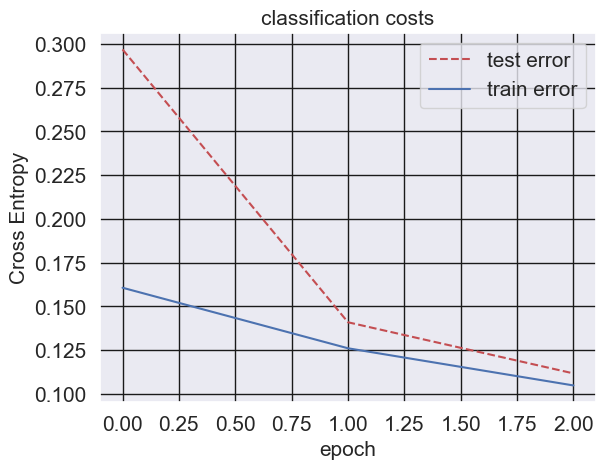

<Figure size 640x480 with 0 Axes>

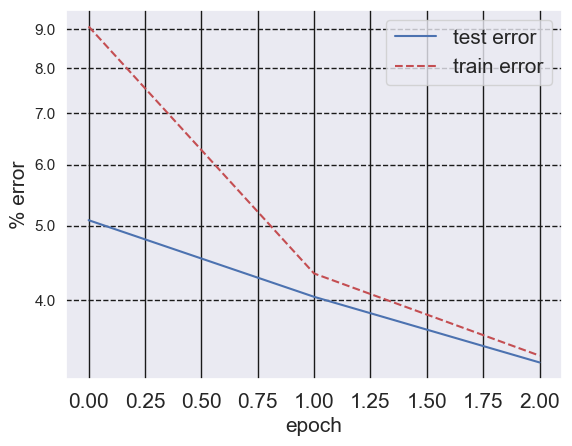

<Figure size 640x480 with 0 Axes>

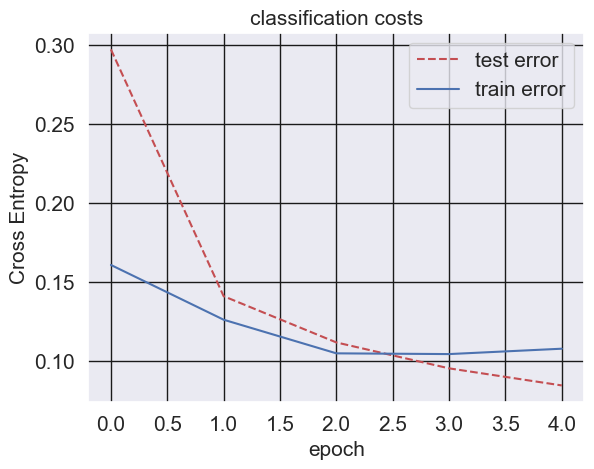

<Figure size 640x480 with 0 Axes>

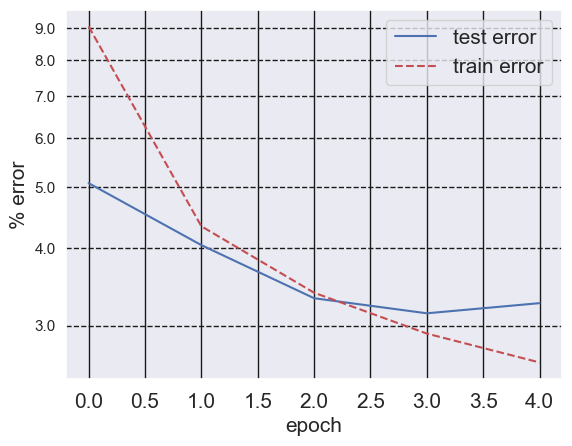

<Figure size 640x480 with 0 Axes>

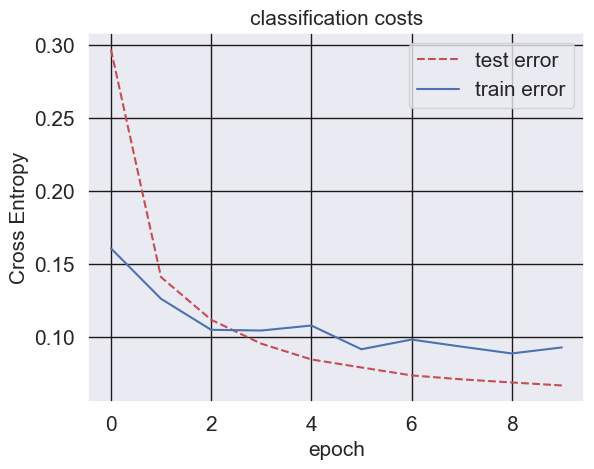

<Figure size 640x480 with 0 Axes>

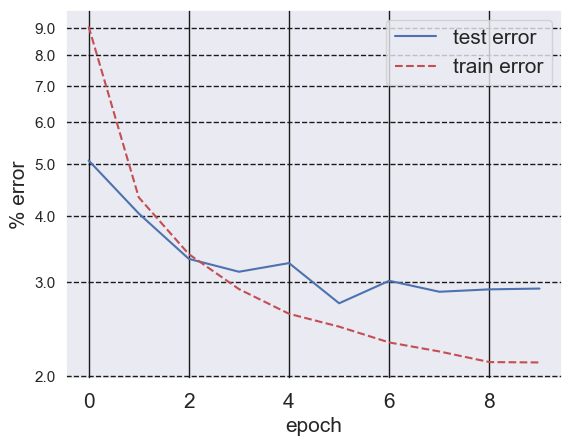

<Figure size 640x480 with 0 Axes>

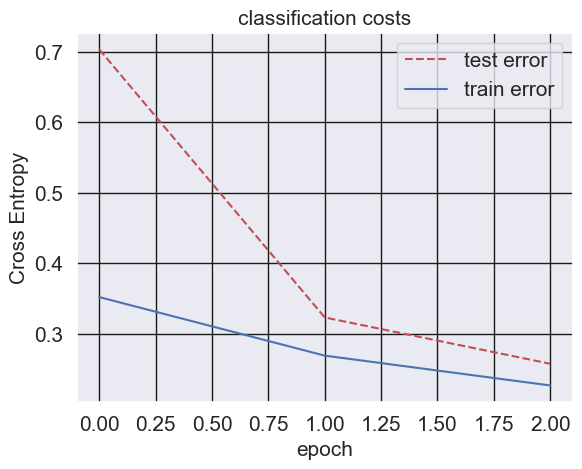

<Figure size 640x480 with 0 Axes>

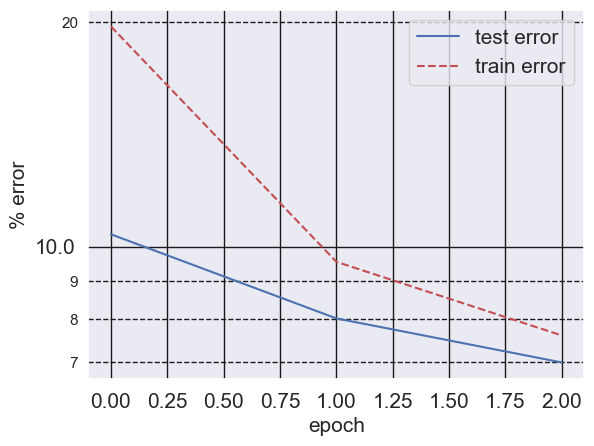

<Figure size 640x480 with 0 Axes>

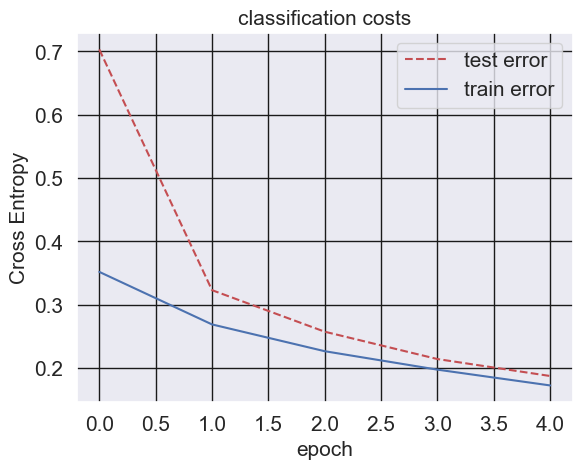

<Figure size 640x480 with 0 Axes>

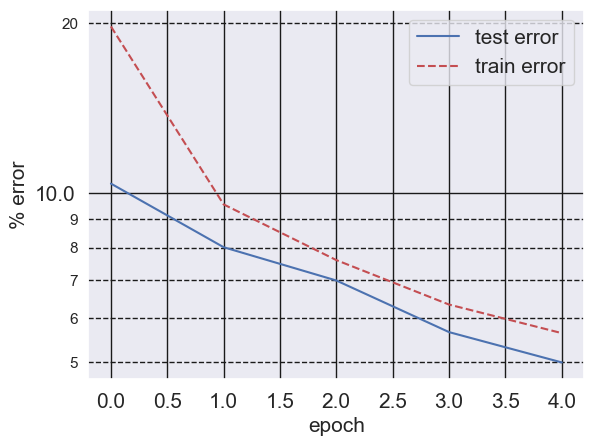

<Figure size 640x480 with 0 Axes>

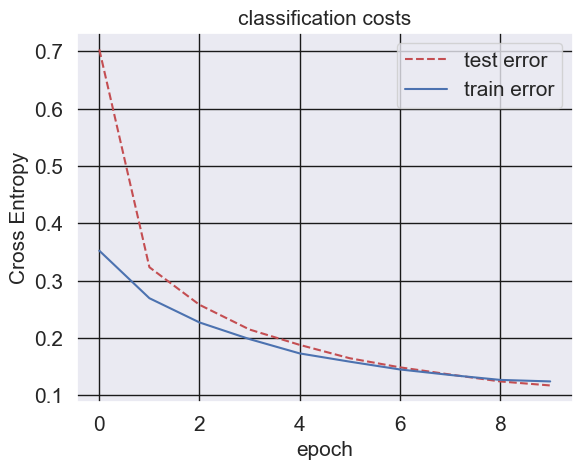

<Figure size 640x480 with 0 Axes>

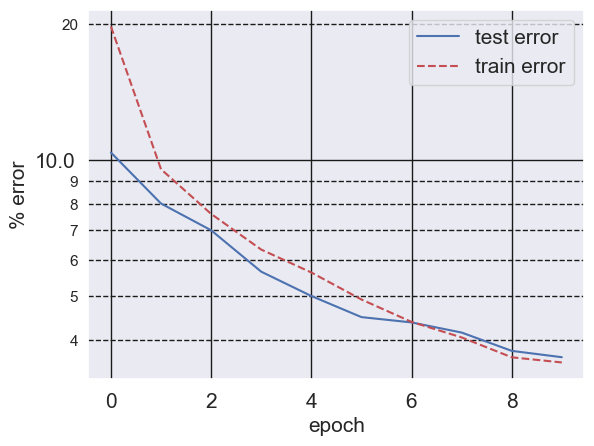

<Figure size 640x480 with 0 Axes>

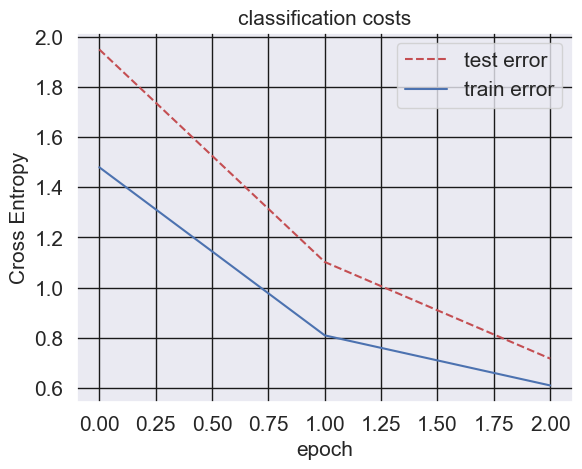

<Figure size 640x480 with 0 Axes>

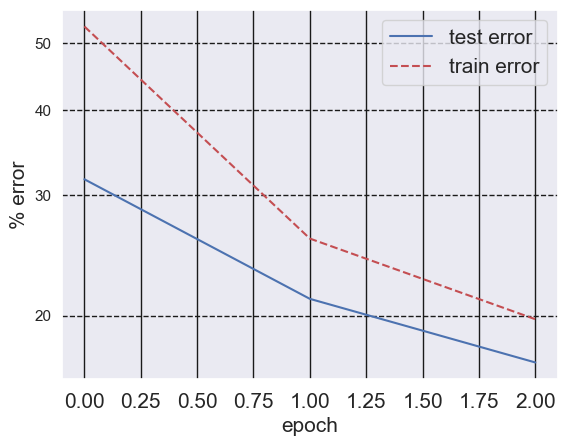

<Figure size 640x480 with 0 Axes>

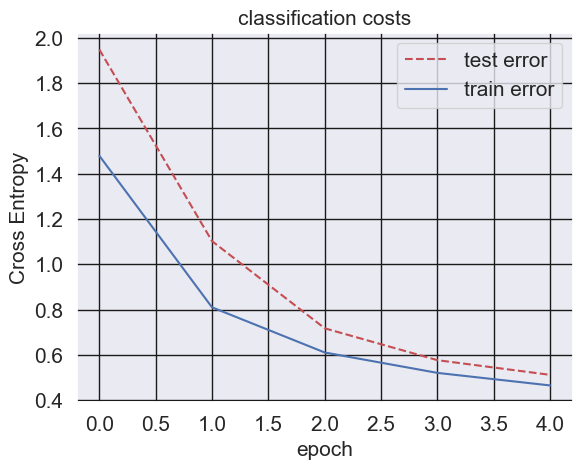

<Figure size 640x480 with 0 Axes>

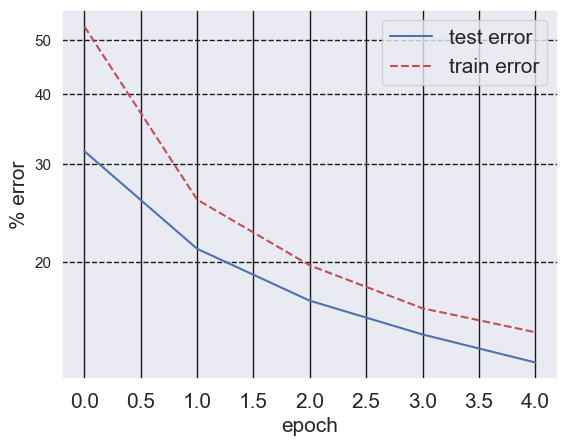

<Figure size 640x480 with 0 Axes>

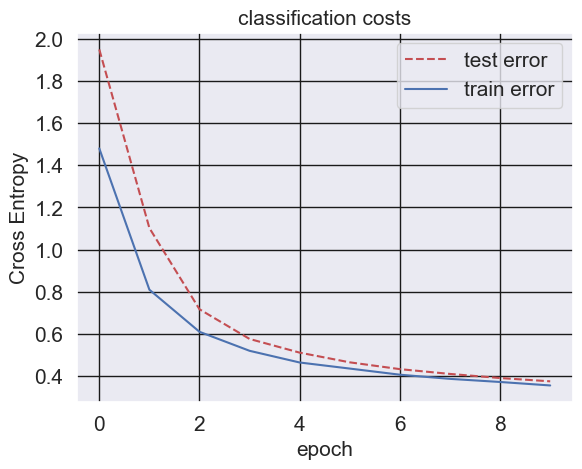

<Figure size 640x480 with 0 Axes>

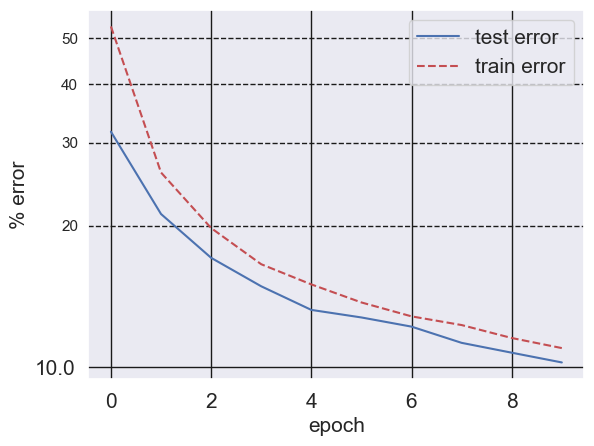

<Figure size 640x480 with 0 Axes>

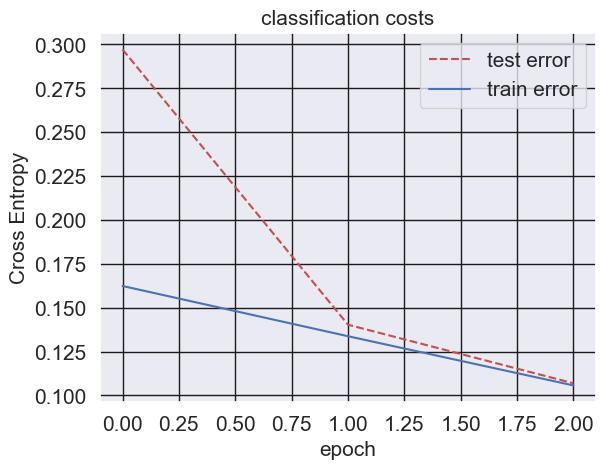

<Figure size 640x480 with 0 Axes>

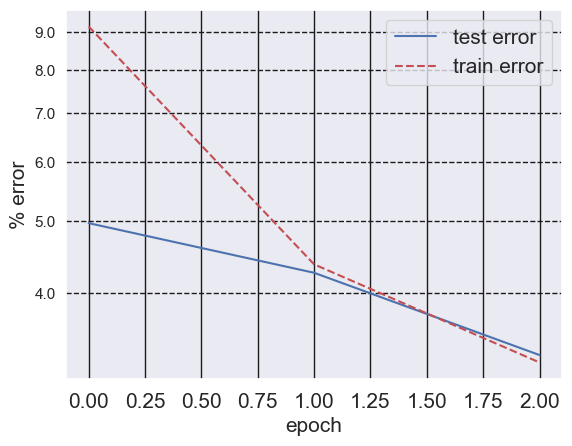

<Figure size 640x480 with 0 Axes>

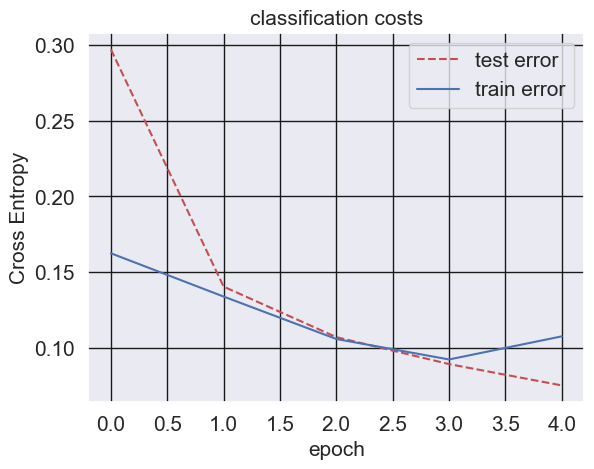

<Figure size 640x480 with 0 Axes>

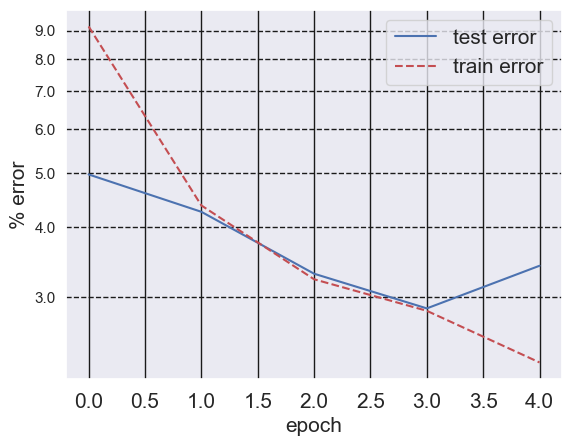

<Figure size 640x480 with 0 Axes>

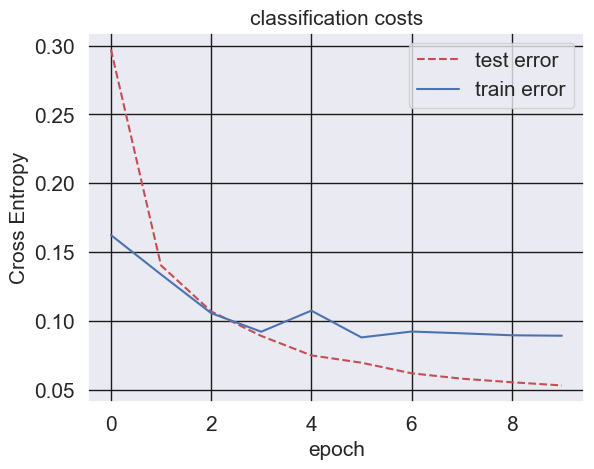

<Figure size 640x480 with 0 Axes>

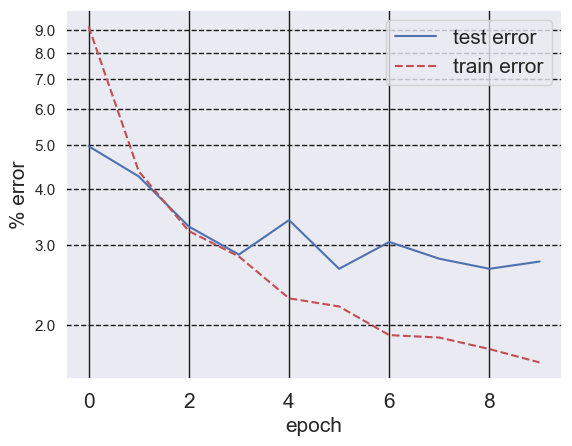

<Figure size 640x480 with 0 Axes>

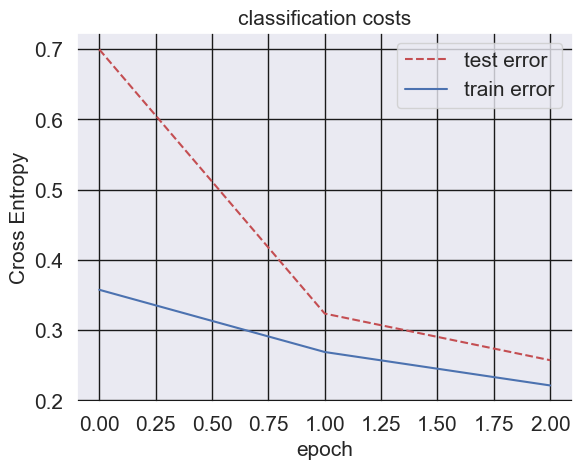

<Figure size 640x480 with 0 Axes>

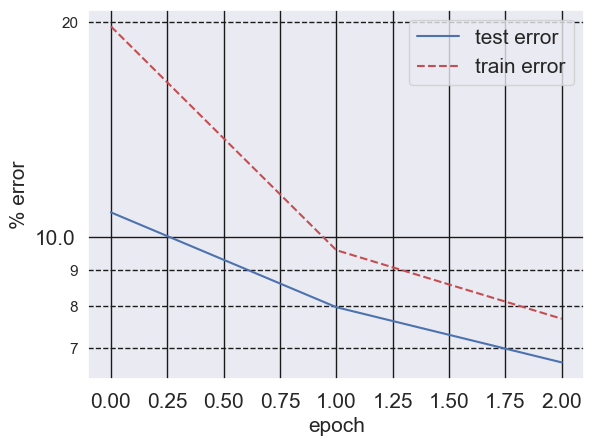

<Figure size 640x480 with 0 Axes>

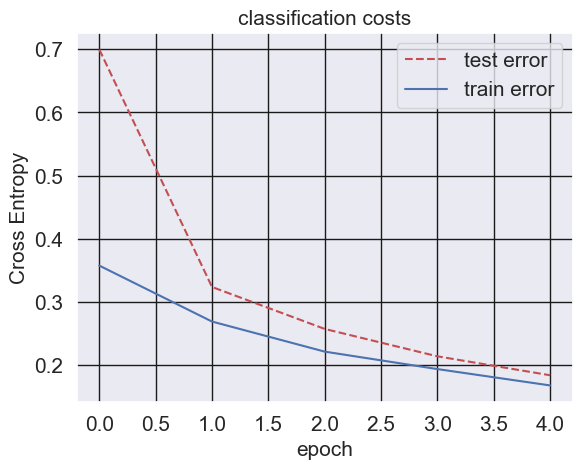

<Figure size 640x480 with 0 Axes>

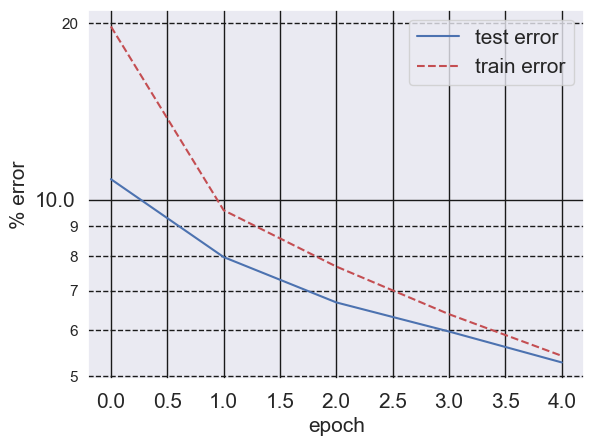

<Figure size 640x480 with 0 Axes>

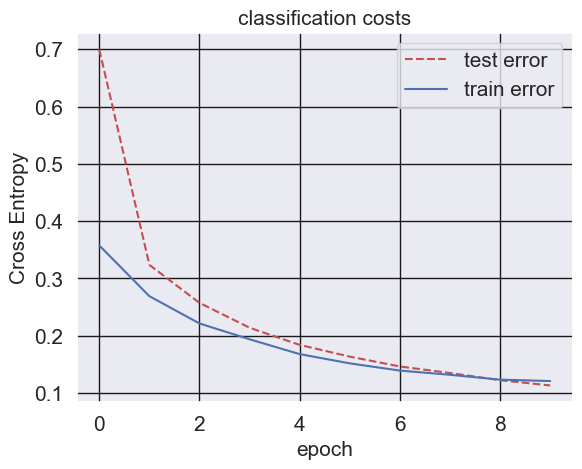

<Figure size 640x480 with 0 Axes>

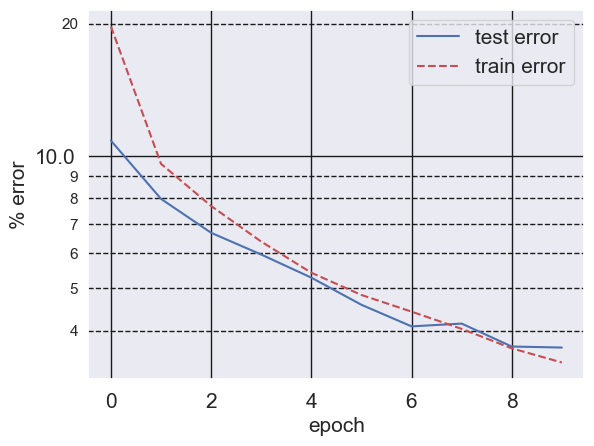

<Figure size 640x480 with 0 Axes>

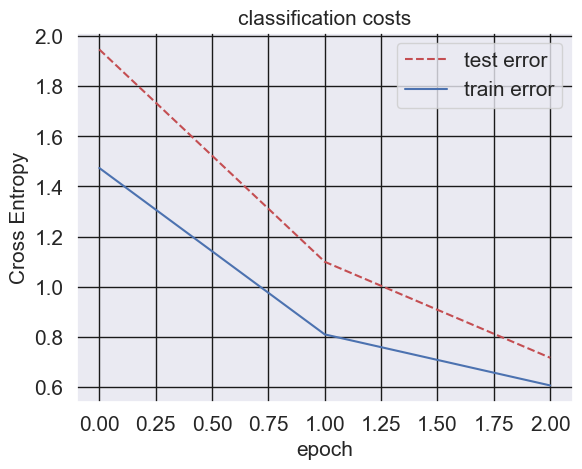

<Figure size 640x480 with 0 Axes>

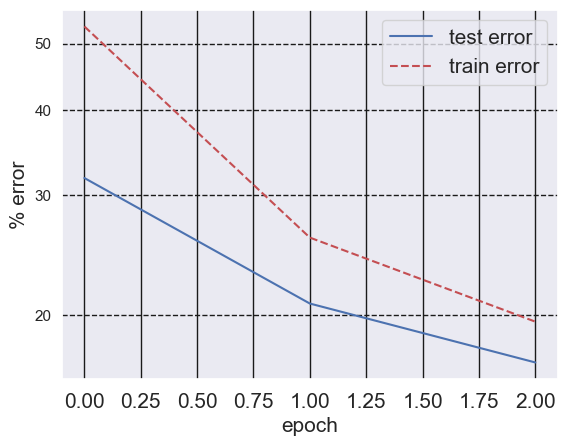

<Figure size 640x480 with 0 Axes>

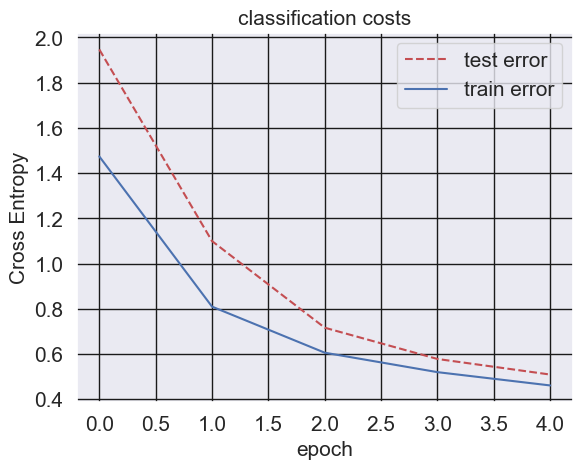

<Figure size 640x480 with 0 Axes>

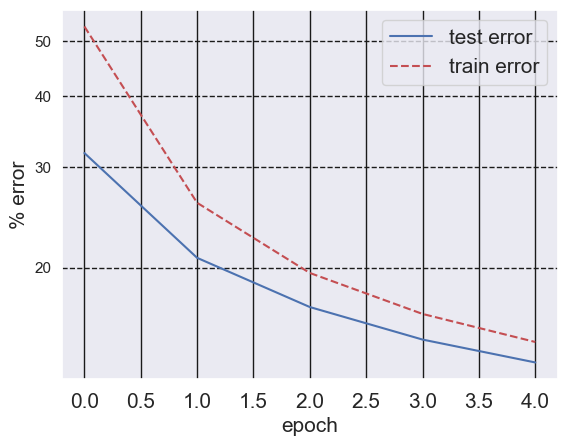

<Figure size 640x480 with 0 Axes>

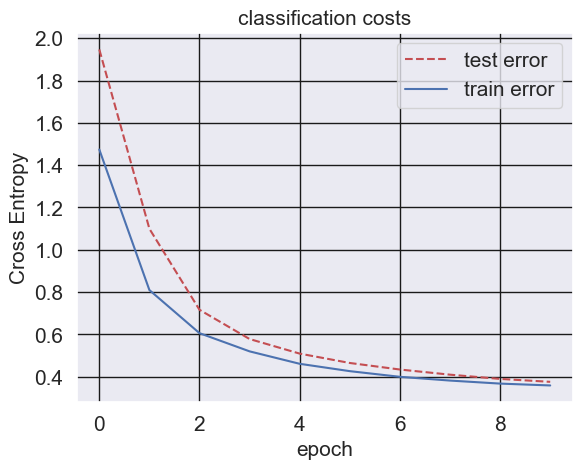

<Figure size 640x480 with 0 Axes>

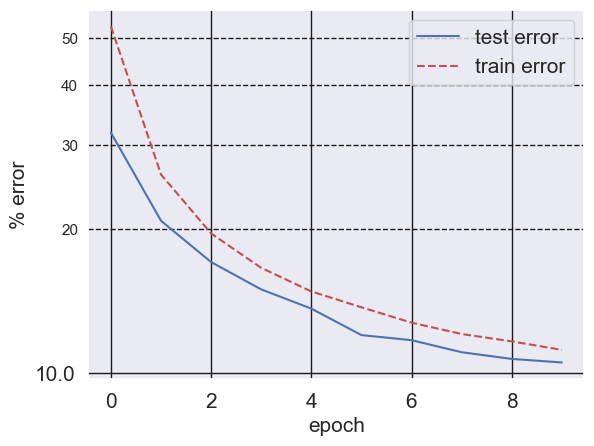

<Figure size 640x480 with 0 Axes>

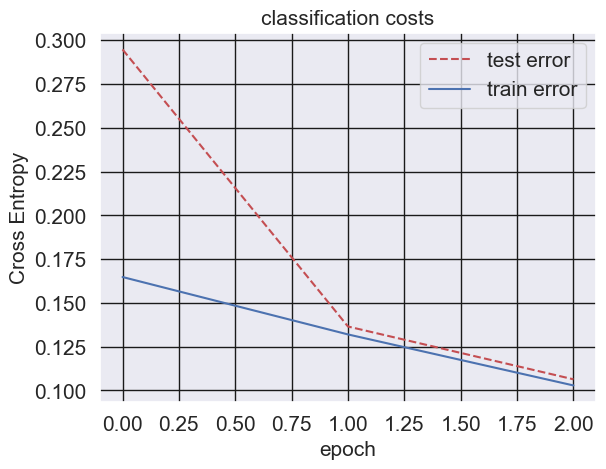

<Figure size 640x480 with 0 Axes>

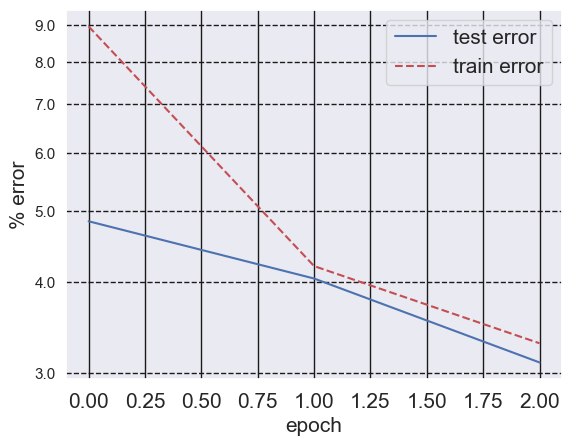

<Figure size 640x480 with 0 Axes>

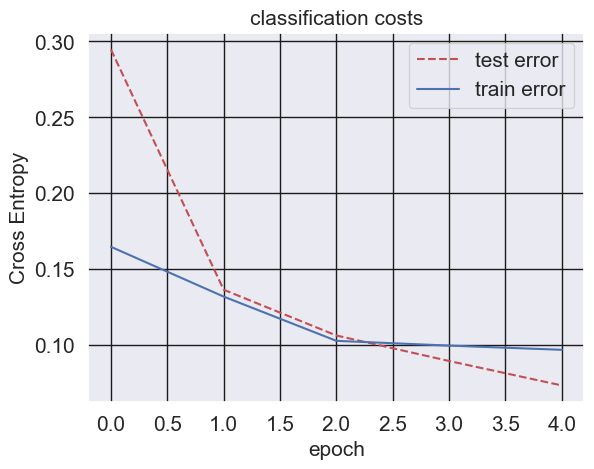

<Figure size 640x480 with 0 Axes>

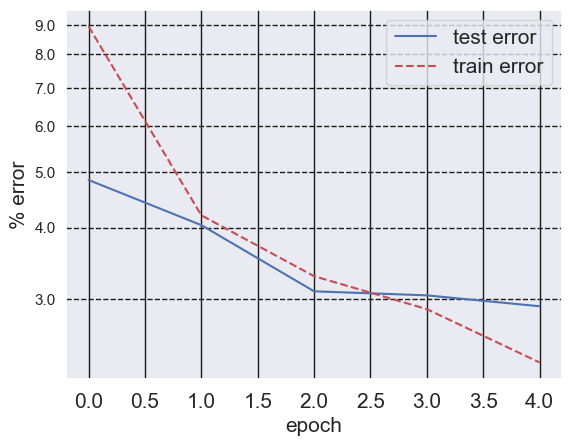

<Figure size 640x480 with 0 Axes>

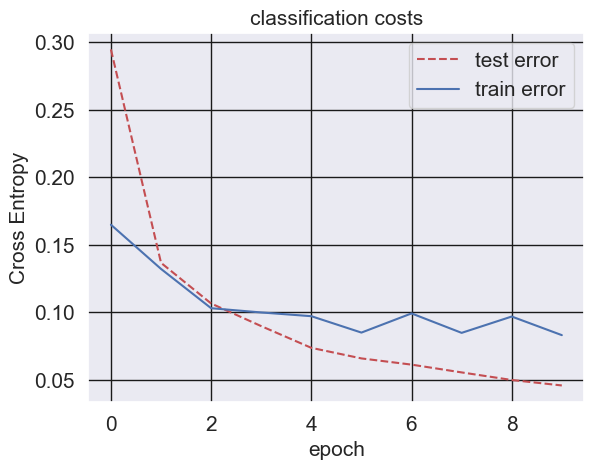

<Figure size 640x480 with 0 Axes>

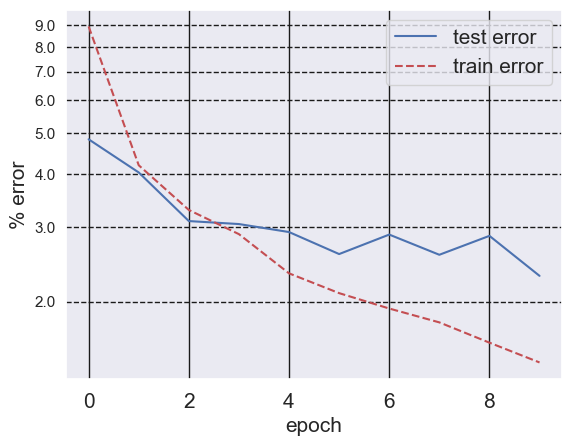

<Figure size 640x480 with 0 Axes>

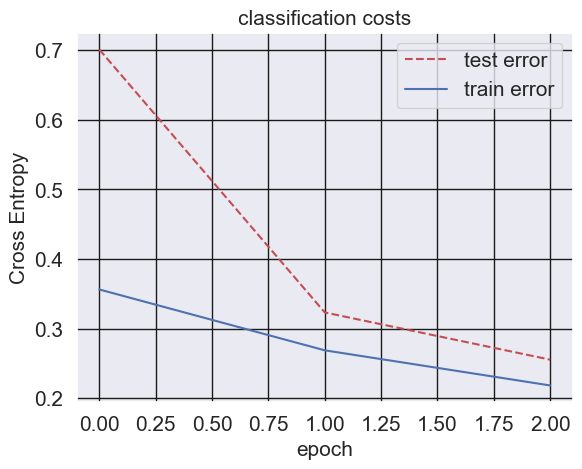

<Figure size 640x480 with 0 Axes>

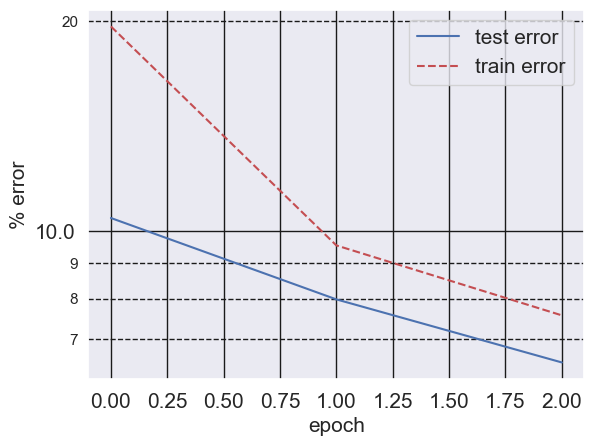

<Figure size 640x480 with 0 Axes>

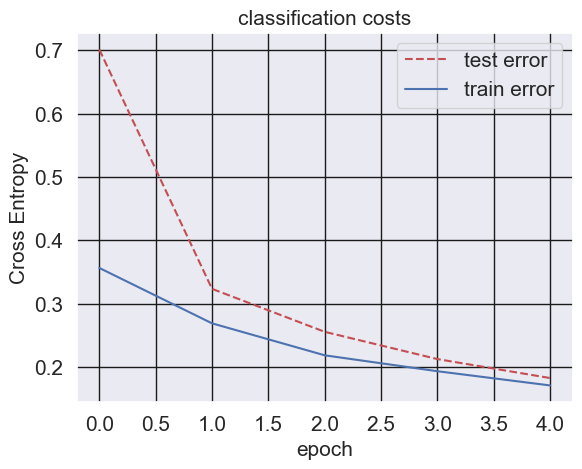

<Figure size 640x480 with 0 Axes>

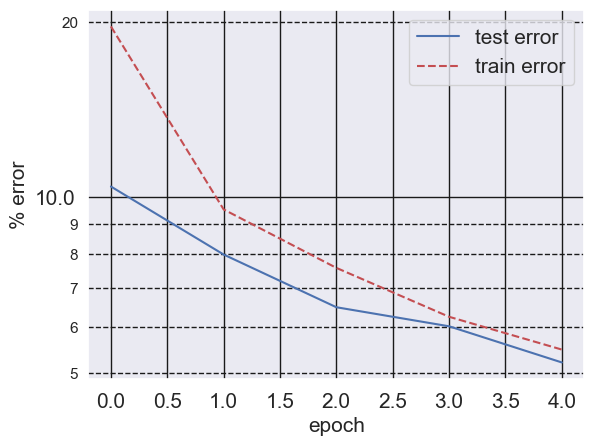

<Figure size 640x480 with 0 Axes>

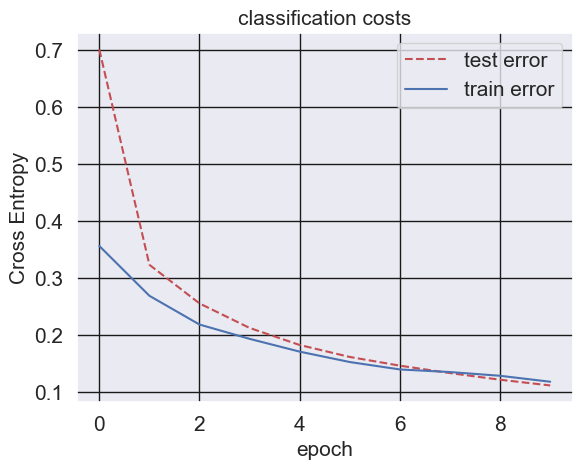

<Figure size 640x480 with 0 Axes>

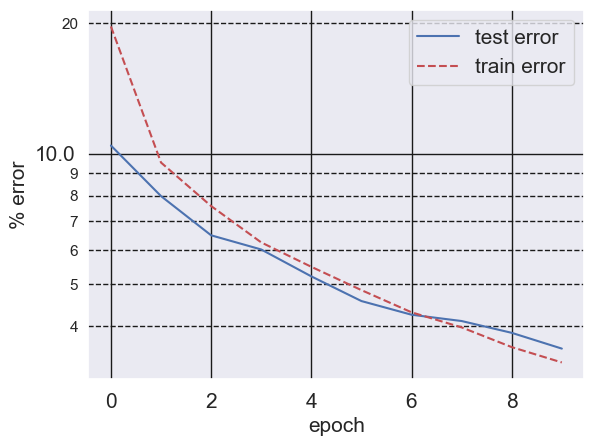

<Figure size 640x480 with 0 Axes>

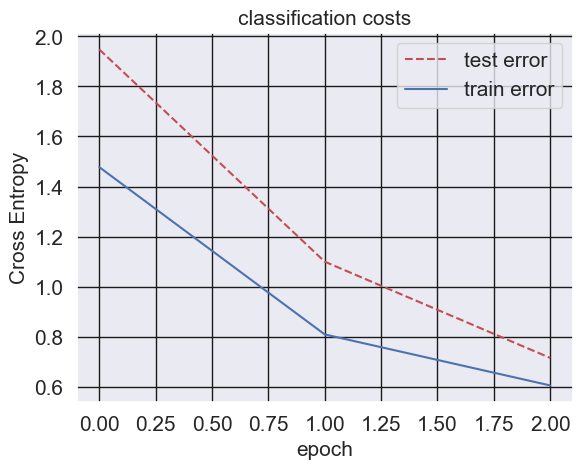

<Figure size 640x480 with 0 Axes>

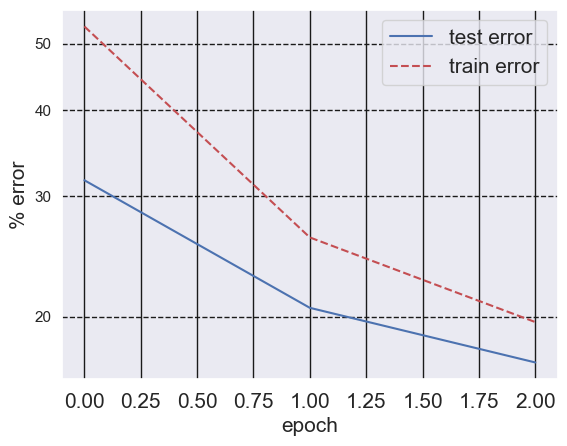

<Figure size 640x480 with 0 Axes>

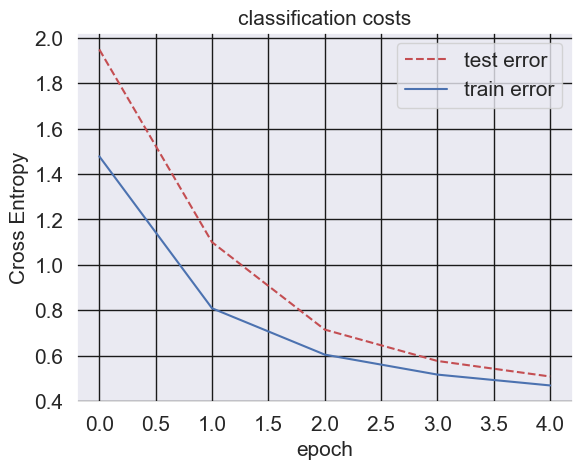

<Figure size 640x480 with 0 Axes>

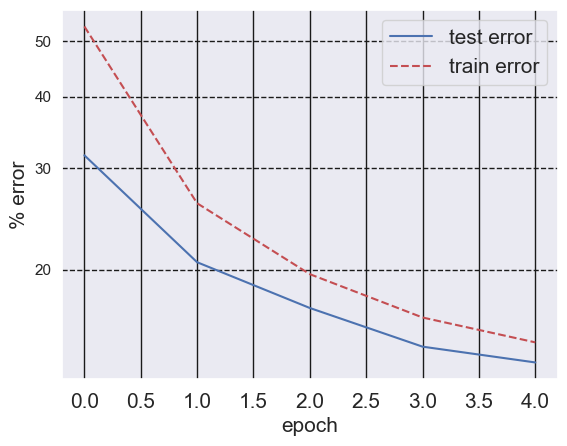

<Figure size 640x480 with 0 Axes>

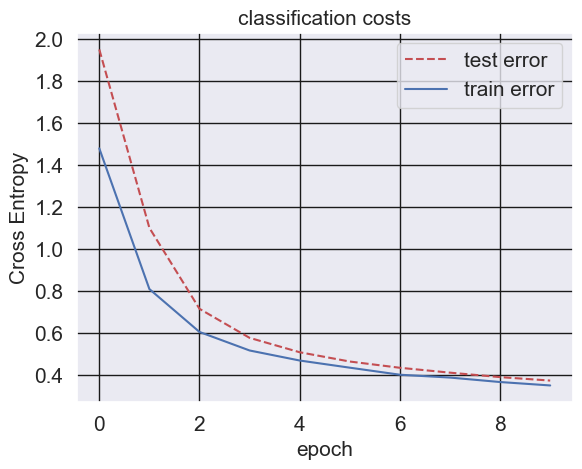

<Figure size 640x480 with 0 Axes>

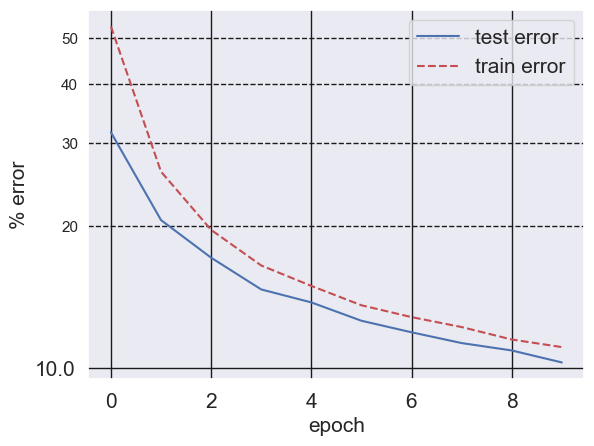

<Figure size 640x480 with 0 Axes>

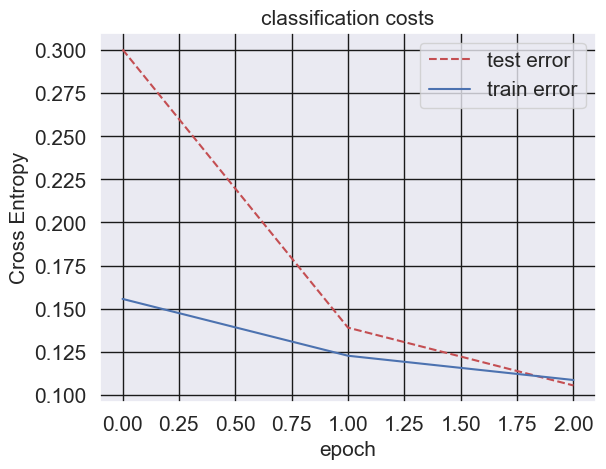

<Figure size 640x480 with 0 Axes>

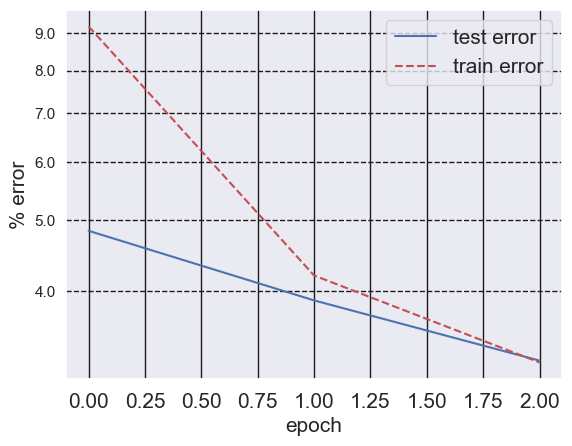

<Figure size 640x480 with 0 Axes>

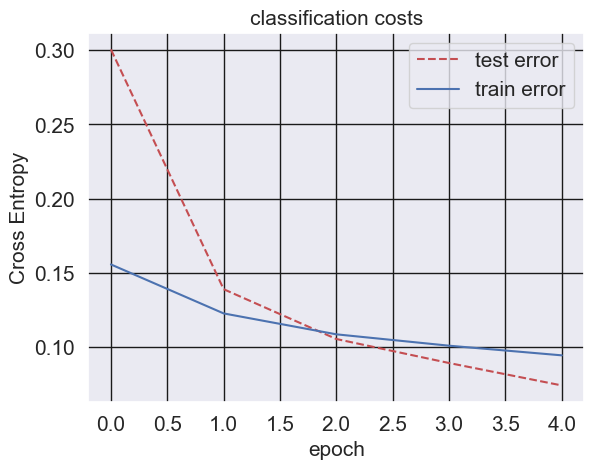

<Figure size 640x480 with 0 Axes>

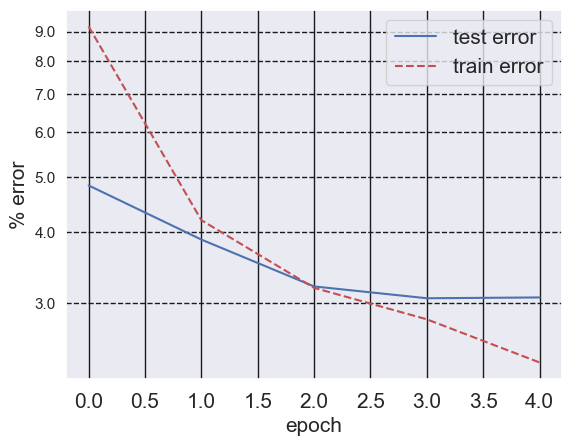

<Figure size 640x480 with 0 Axes>

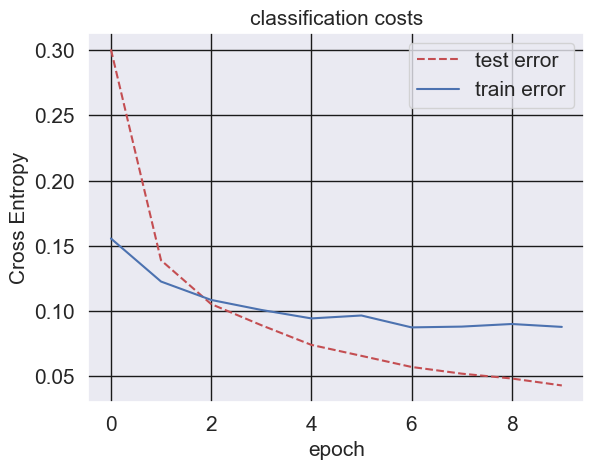

<Figure size 640x480 with 0 Axes>

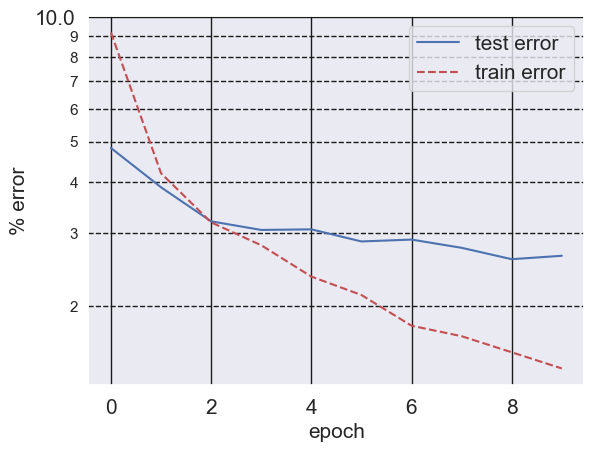

<Figure size 640x480 with 0 Axes>

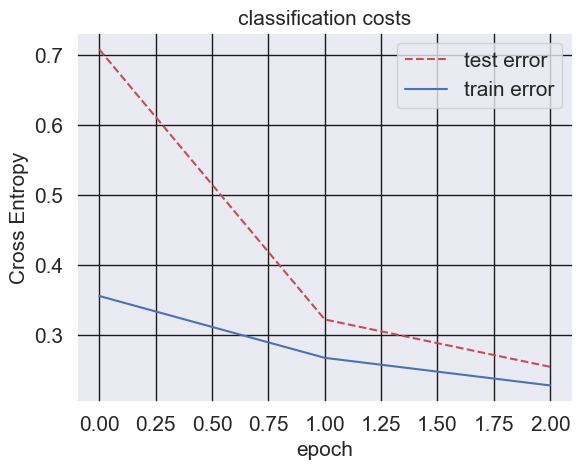

<Figure size 640x480 with 0 Axes>

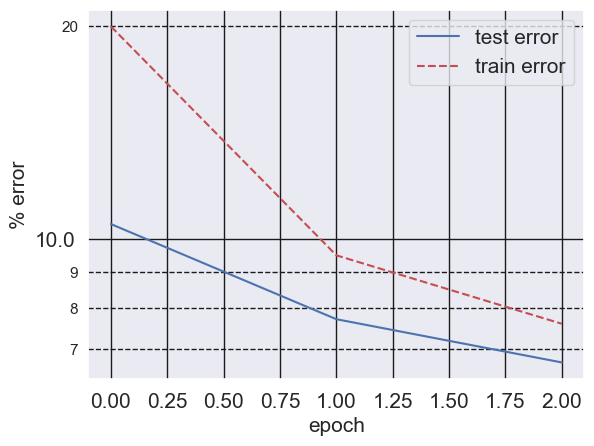

<Figure size 640x480 with 0 Axes>

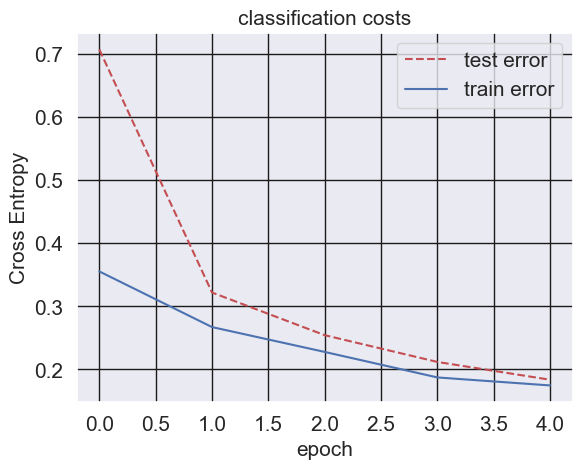

<Figure size 640x480 with 0 Axes>

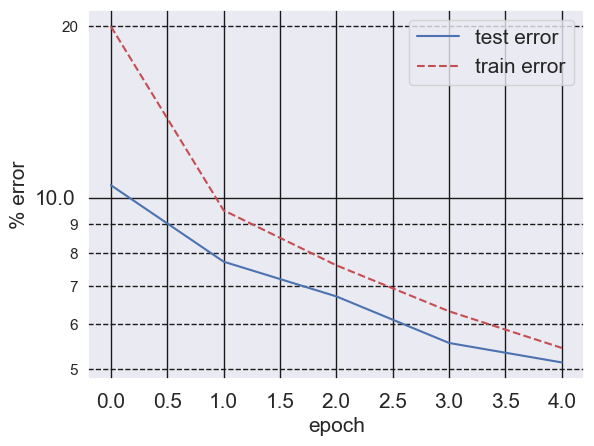

<Figure size 640x480 with 0 Axes>

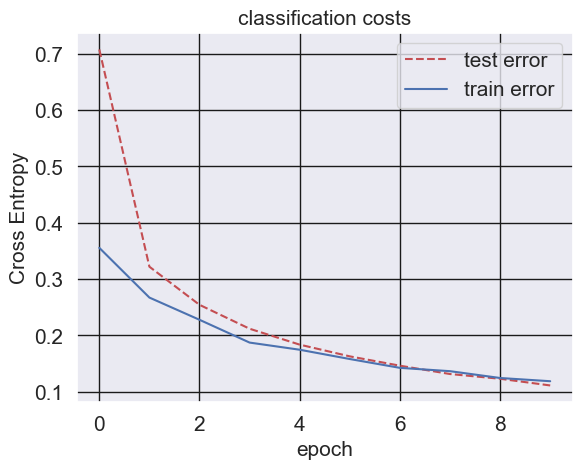

<Figure size 640x480 with 0 Axes>

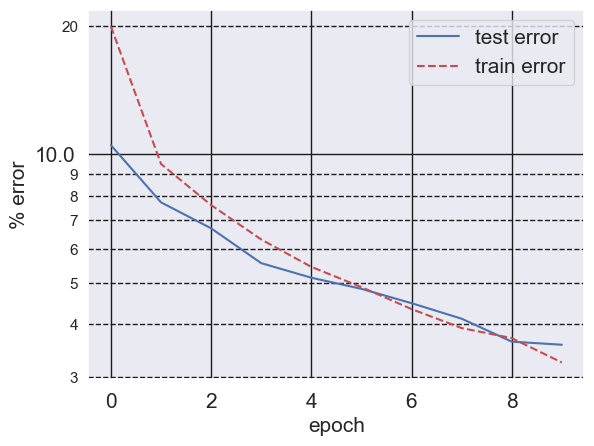

<Figure size 640x480 with 0 Axes>

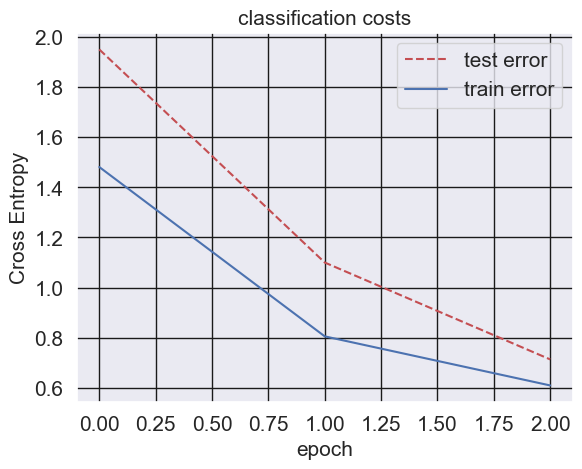

<Figure size 640x480 with 0 Axes>

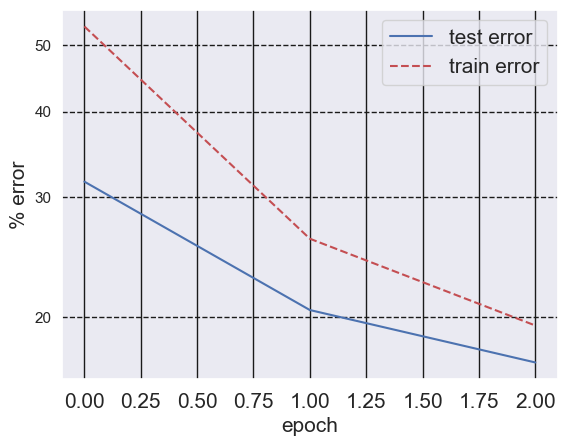

<Figure size 640x480 with 0 Axes>

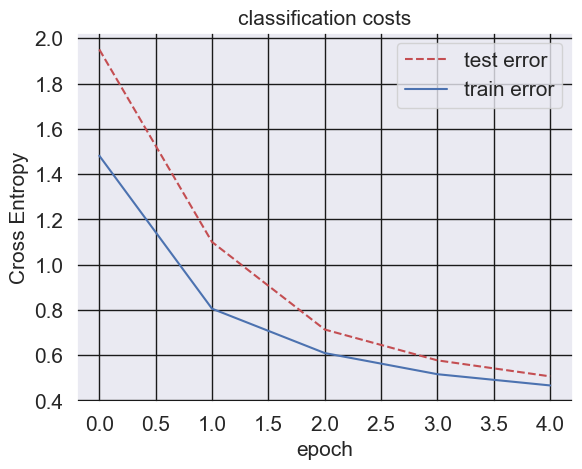

<Figure size 640x480 with 0 Axes>

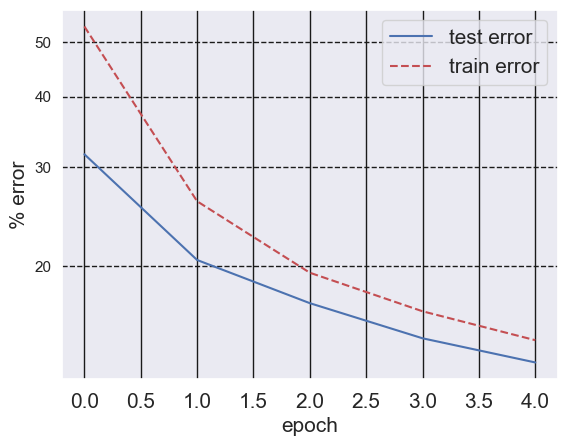

<Figure size 640x480 with 0 Axes>

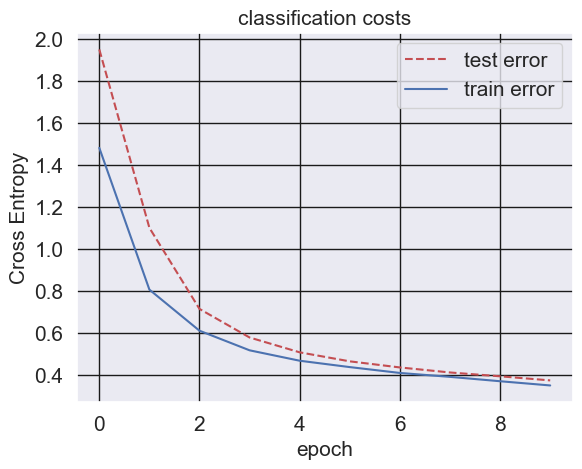

<Figure size 640x480 with 0 Axes>

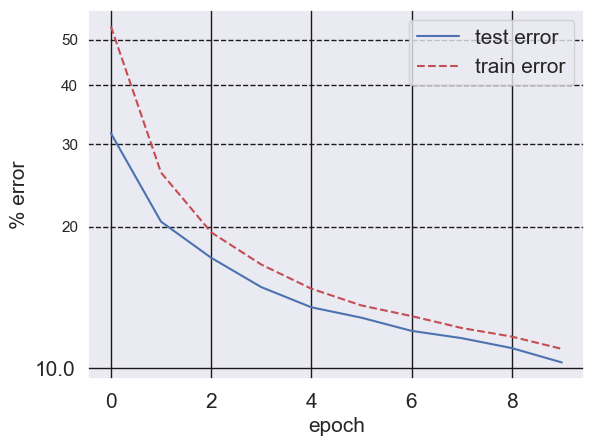

<Figure size 640x480 with 0 Axes>

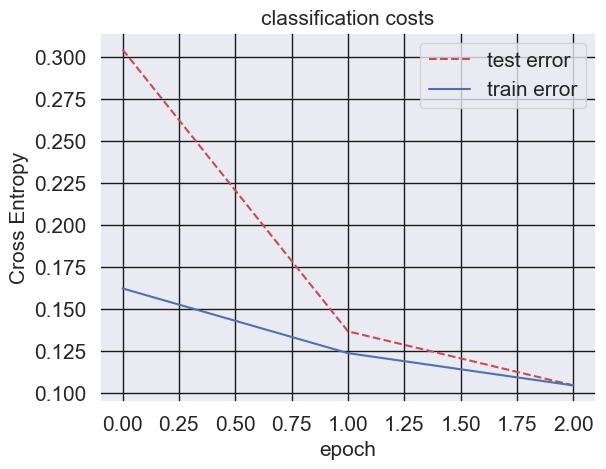

<Figure size 640x480 with 0 Axes>

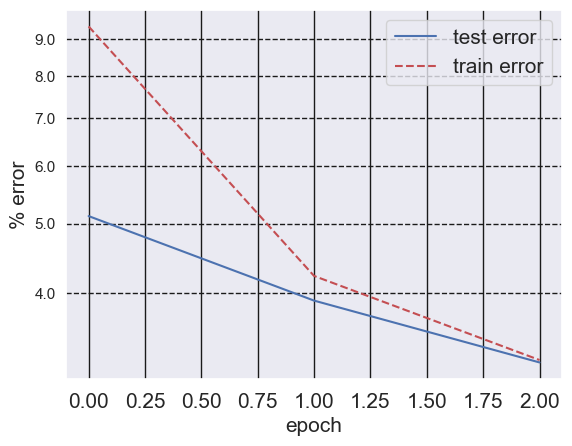

<Figure size 640x480 with 0 Axes>

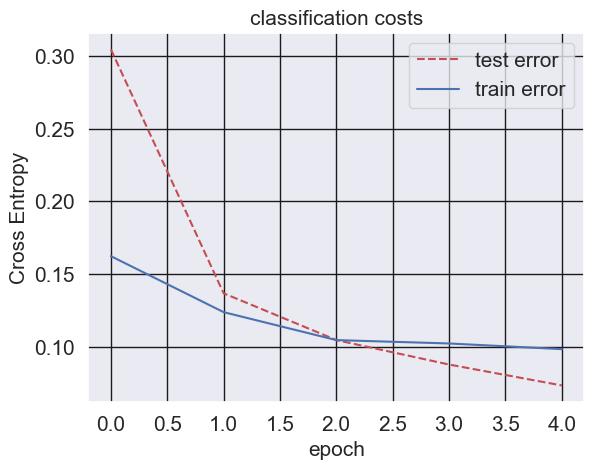

<Figure size 640x480 with 0 Axes>

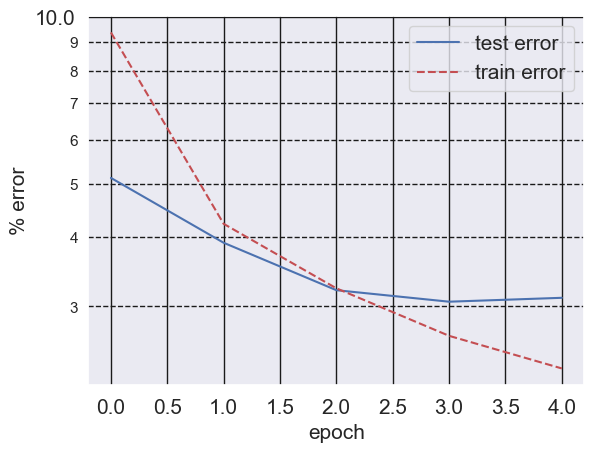

<Figure size 640x480 with 0 Axes>

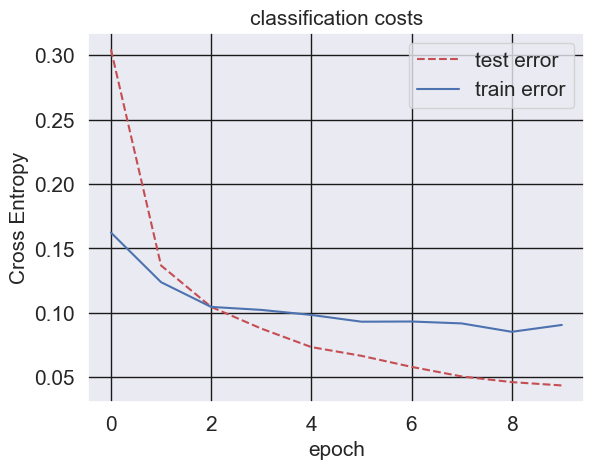

<Figure size 640x480 with 0 Axes>

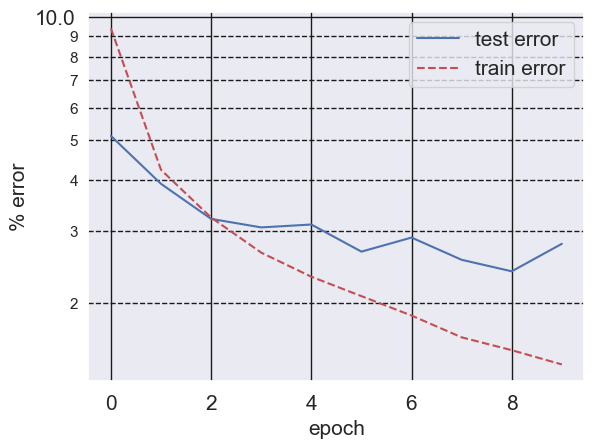

<Figure size 640x480 with 0 Axes>

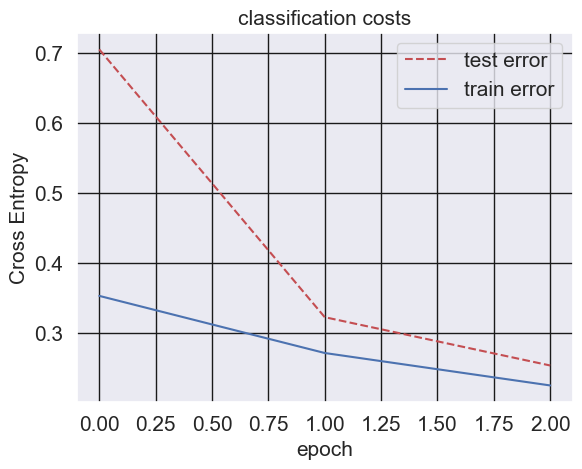

<Figure size 640x480 with 0 Axes>

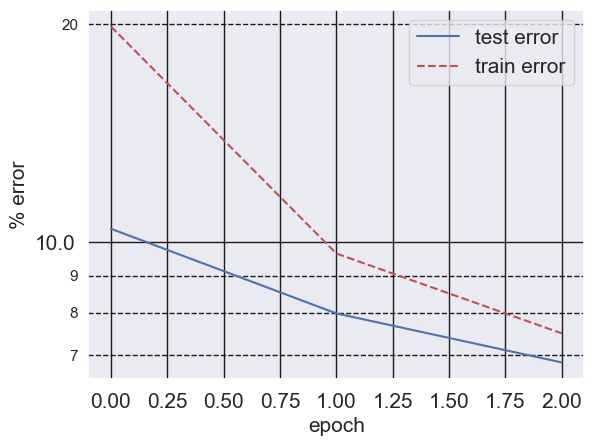

<Figure size 640x480 with 0 Axes>

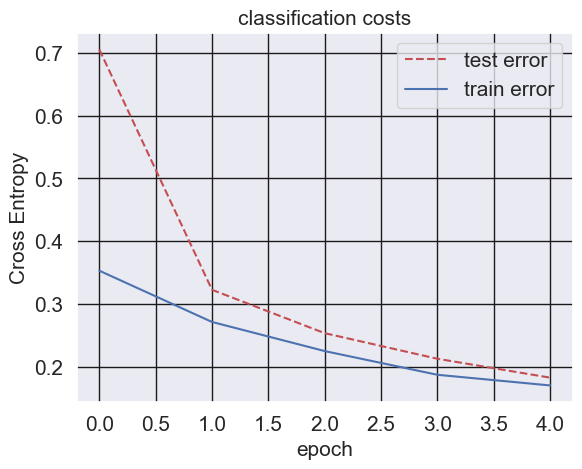

<Figure size 640x480 with 0 Axes>

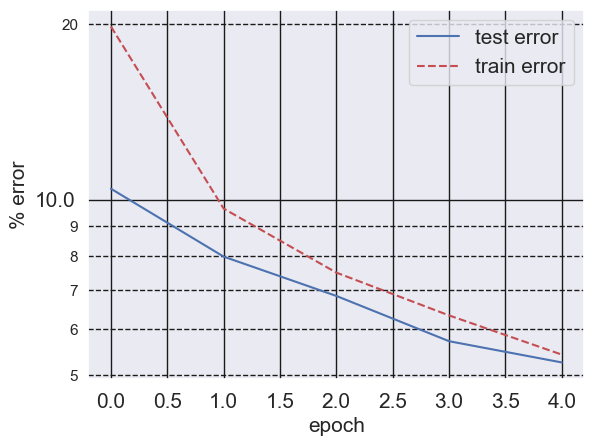

<Figure size 640x480 with 0 Axes>

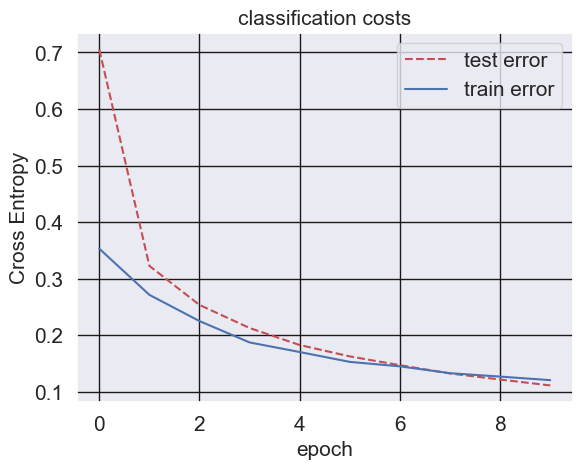

<Figure size 640x480 with 0 Axes>

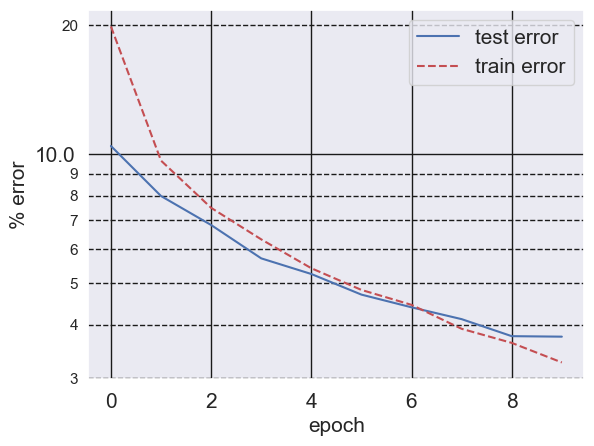

<Figure size 640x480 with 0 Axes>

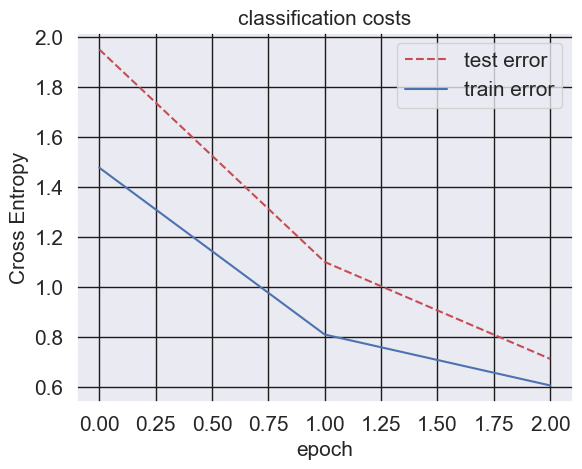

<Figure size 640x480 with 0 Axes>

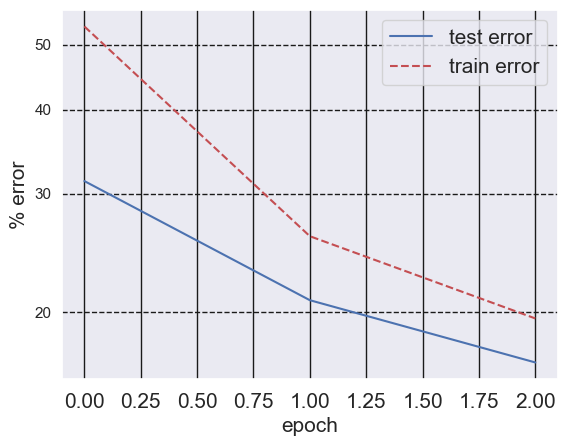

<Figure size 640x480 with 0 Axes>

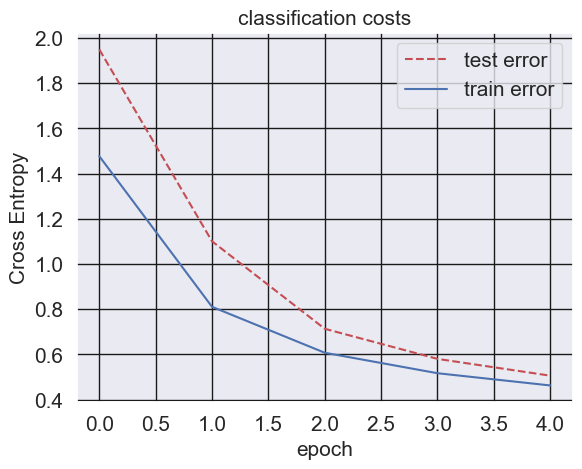

<Figure size 640x480 with 0 Axes>

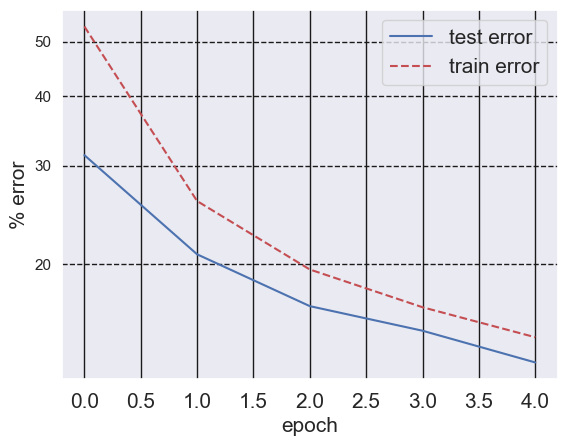

<Figure size 640x480 with 0 Axes>

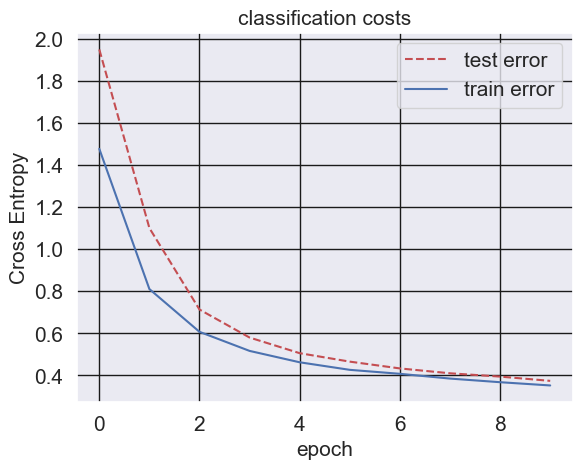

<Figure size 640x480 with 0 Axes>

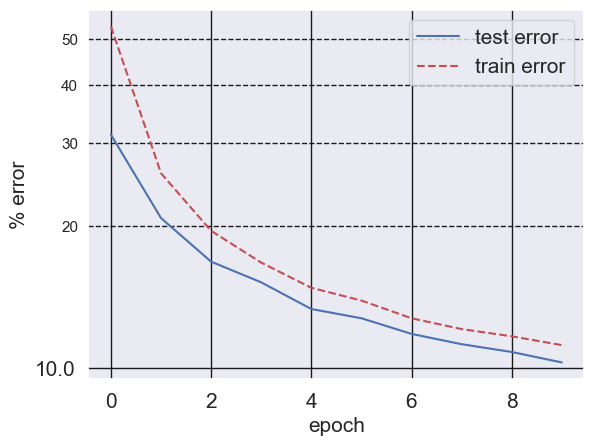

In [13]:
wandb.agent(sweep_id, function=main, count= 45)

## inference with sampling on test set (performed in wandb main function)

In [ ]:
batch_size = 200

if use_cuda:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

else:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=4)
test_cost = 0  # Note that these are per sample
test_err = 0
nb_samples = 0
test_predictions = np.zeros((10000, 10))

Nsamples = 100

net.set_mode_train(False)

for j, (x, y) in enumerate(valloader):
    cost, err, probs = net.sample_eval(x, y, Nsamples, logits=False) # , logits=True

    test_cost += cost
    test_err += err.cpu().numpy()
    test_predictions[nb_samples:nb_samples+len(x), :] = probs.numpy()
    nb_samples += len(x)

# test_cost /= nb_samples
test_err /= nb_samples
cprint('b', '    Loglike = %5.6f, err = %1.6f\n' % (-test_cost, test_err))

